In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[:1617]
y = digits.target[:1617]

In [3]:
necoc = 100
generations = int(3000/necoc)
generations

30

In [4]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [5]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [6]:
def get_winner(class1):
    
    numbers = [*range(10)] # number 2 > number 1
    number_of_classification = len(numbers)
    #number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

        
    class2 = []

    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = 1617
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            real_outputs = np.array(x_outputs).reshape(samplesize,)
            real_outputs_onehot = np.zeros(px_outputs.shape)
            for iiii in range(samplesize):
                real_outputs_onehot[iiii][real_outputs[iiii]] = 1

            ce = cross_entropy(px_outputs, real_outputs_onehot)
            fitness = 1 - ce
            genome.fitness = fitness

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, generations)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist2")
    [stats, winner] = run(config_path)
    
    return winner

In [7]:
import numpy as np
import random
while True:
    number_codes = []
    for i in range(2**(10-1), 2**10-1):
        for j in bin(i).split('b')[1]:
            number_codes.append(int(j))
    number_codes = np.array(number_codes).reshape(2**9 - 1,10).T     

    slice = random.sample(range(511), necoc)

    number_codes = number_codes[:,slice].tolist()

    classes = []
    for i in range(necoc):
        code_list = np.array(number_codes).T[i]
        classes.append(np.where(code_list==1)[0].tolist())

    matrix_errors = []

    for i in range(9):
        for j in range(i+1,10):
            matrix_errors.append(necoc - np.sum(np.array(number_codes[i]) == np.array(number_codes[j])))
    min_error = np.min(matrix_errors)
    if min_error != 0:
        print(min_error)
        #print(number_codes)
        break

39


In [8]:
len(number_codes[0])

100

In [9]:
winner_list = []

for i,class1 in enumerate(classes):
    print("running:{}/100".format(i))
    winner = get_winner(class1)
    winner_list.append(winner)

running:0/100
number of class1:1129
number of class2:488

 ****** Running generation 0 ****** 

Population's average fitness: 0.09486 stdev: 0.23721
Best fitness: 0.40214 - size: (2, 13) - species 3 - id 90
Average adjusted fitness: 0.633
Mean genetic distance 2.956, standard deviation 0.441
Population of 200 members in 32 species
Total extinctions: 0
Generation time: 18.250 sec

 ****** Running generation 1 ****** 

Population's average fitness: -0.95775 stdev: 2.68770
Best fitness: 0.41482 - size: (3, 14) - species 6 - id 369
Average adjusted fitness: 0.847
Mean genetic distance 3.049, standard deviation 0.463
Population of 203 members in 38 species
Total extinctions: 0
Generation time: 24.025 sec (21.137 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.58310 stdev: 3.63314
Best fitness: 0.42938 - size: (3, 16) - species 11 - id 477
Average adjusted fitness: 0.780
Mean genetic distance 3.061, standard deviation 0.471
Population of 204 members in 39 spe

Population's average fitness: -0.73195 stdev: 2.88202
Best fitness: 0.49834 - size: (6, 18) - species 10 - id 2072
Average adjusted fitness: 0.901
Mean genetic distance 3.180, standard deviation 0.508
Population of 195 members in 30 species
Total extinctions: 0
Generation time: 20.071 sec (19.223 average)

 ****** Running generation 25 ****** 

Population's average fitness: -0.43549 stdev: 2.34967
Best fitness: 0.49834 - size: (6, 18) - species 10 - id 2072
Average adjusted fitness: 0.927
Mean genetic distance 3.152, standard deviation 0.516
Population of 193 members in 29 species
Total extinctions: 0
Generation time: 19.804 sec (19.296 average)

 ****** Running generation 26 ****** 

Population's average fitness: -0.89085 stdev: 2.98800
Best fitness: 0.49834 - size: (6, 18) - species 10 - id 2072
Average adjusted fitness: 0.902
Mean genetic distance 3.135, standard deviation 0.512
Population of 198 members in 29 species
Total extinctions: 0
Generation time: 19.693 sec (19.317 average)

Population's average fitness: -0.91219 stdev: 2.85597
Best fitness: 0.36620 - size: (8, 22) - species 33 - id 2169
Average adjusted fitness: 0.876
Mean genetic distance 3.149, standard deviation 0.505
Population of 196 members in 35 species
Total extinctions: 0
Generation time: 17.580 sec (17.662 average)

 ****** Running generation 19 ****** 

Population's average fitness: -0.69261 stdev: 2.56057
Best fitness: 0.36628 - size: (7, 21) - species 33 - id 2675
Average adjusted fitness: 0.894
Mean genetic distance 3.149, standard deviation 0.510
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 18.111 sec (17.754 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.90130 stdev: 2.84919
Best fitness: 0.36628 - size: (7, 21) - species 33 - id 2675
Average adjusted fitness: 0.876
Mean genetic distance 3.179, standard deviation 0.501
Population of 204 members in 35 species
Total extinctions: 0
Generation time: 18.812 sec (17.891 average)

Population's average fitness: -0.75038 stdev: 2.65991
Best fitness: 0.46601 - size: (2, 13) - species 6 - id 804
Average adjusted fitness: 0.893
Mean genetic distance 3.065, standard deviation 0.502
Population of 196 members in 32 species
Total extinctions: 0
Generation time: 18.439 sec (17.151 average)

 ****** Running generation 13 ****** 

Population's average fitness: -0.92376 stdev: 2.86522
Best fitness: 0.46601 - size: (2, 13) - species 6 - id 804
Average adjusted fitness: 0.884
Mean genetic distance 3.085, standard deviation 0.506
Population of 198 members in 32 species
Total extinctions: 0
Generation time: 17.756 sec (17.363 average)

 ****** Running generation 14 ****** 

Population's average fitness: -0.83423 stdev: 2.88095
Best fitness: 0.46601 - size: (2, 13) - species 6 - id 804
Average adjusted fitness: 0.890
Mean genetic distance 3.078, standard deviation 0.516
Population of 196 members in 32 species
Total extinctions: 0
Generation time: 17.948 sec (17.529 average)

 ***

Population's average fitness: -1.55673 stdev: 3.29794
Best fitness: 0.44760 - size: (3, 17) - species 10 - id 1130
Average adjusted fitness: 0.804
Mean genetic distance 3.147, standard deviation 0.500
Population of 206 members in 33 species
Total extinctions: 0
Generation time: 17.723 sec (16.235 average)

 ****** Running generation 7 ****** 

Population's average fitness: -1.17111 stdev: 3.12831
Best fitness: 0.44760 - size: (3, 17) - species 10 - id 1130
Average adjusted fitness: 0.822
Mean genetic distance 3.152, standard deviation 0.496
Population of 204 members in 34 species
Total extinctions: 0
Generation time: 18.237 sec (16.485 average)

 ****** Running generation 8 ****** 

Population's average fitness: -1.24793 stdev: 3.04359
Best fitness: 0.44760 - size: (3, 17) - species 10 - id 1130
Average adjusted fitness: 0.824
Mean genetic distance 3.147, standard deviation 0.499
Population of 196 members in 35 species
Total extinctions: 0
Generation time: 18.308 sec (16.688 average)



Population's average fitness: 0.07061 stdev: 0.13644
Best fitness: 0.36290 - size: (2, 13) - species 5 - id 110
Average adjusted fitness: 0.221
Mean genetic distance 2.983, standard deviation 0.498
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 14.118 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.44030 stdev: 3.03675
Best fitness: 0.36290 - size: (2, 13) - species 2 - id 110
Average adjusted fitness: 0.734
Mean genetic distance 3.078, standard deviation 0.507
Population of 201 members in 34 species
Total extinctions: 0
Generation time: 15.069 sec (14.594 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.84868 stdev: 3.42555
Best fitness: 0.36961 - size: (4, 16) - species 34 - id 526
Average adjusted fitness: 0.715
Mean genetic distance 3.114, standard deviation 0.489
Population of 207 members in 36 species
Total extinctions: 0
Generation time: 15.907 sec (15.032 average)

 ****** Running generat

Population's average fitness: -1.05105 stdev: 2.77295
Best fitness: 0.45497 - size: (5, 17) - species 5 - id 3188
Average adjusted fitness: 0.835
Mean genetic distance 3.242, standard deviation 0.501
Population of 201 members in 37 species
Total extinctions: 0
Generation time: 19.992 sec (19.805 average)

 ****** Running generation 25 ****** 

Population's average fitness: -1.09968 stdev: 2.90755
Best fitness: 0.45497 - size: (5, 17) - species 5 - id 3188
Average adjusted fitness: 0.816
Mean genetic distance 3.250, standard deviation 0.492
Population of 205 members in 37 species
Total extinctions: 0
Generation time: 20.665 sec (19.992 average)

 ****** Running generation 26 ****** 

Population's average fitness: -1.10233 stdev: 2.98185
Best fitness: 0.45497 - size: (5, 17) - species 5 - id 3188
Average adjusted fitness: 0.830
Mean genetic distance 3.249, standard deviation 0.493
Population of 203 members in 37 species
Total extinctions: 0
Generation time: 21.215 sec (20.253 average)

 

Population's average fitness: -0.86279 stdev: 2.77093
Best fitness: 0.47855 - size: (5, 21) - species 6 - id 1846
Average adjusted fitness: 0.887
Mean genetic distance 3.165, standard deviation 0.507
Population of 198 members in 36 species
Total extinctions: 0
Generation time: 19.192 sec (18.719 average)

 ****** Running generation 19 ****** 

Population's average fitness: -0.72561 stdev: 2.61781
Best fitness: 0.47855 - size: (5, 21) - species 6 - id 1846
Average adjusted fitness: 0.890
Mean genetic distance 3.186, standard deviation 0.505
Population of 198 members in 34 species
Total extinctions: 0
Generation time: 19.282 sec (18.856 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.86414 stdev: 2.71081
Best fitness: 0.47855 - size: (5, 21) - species 6 - id 1846
Average adjusted fitness: 0.883
Mean genetic distance 3.184, standard deviation 0.503
Population of 192 members in 35 species
Total extinctions: 0
Generation time: 19.663 sec (18.988 average)

 

Population's average fitness: -1.04803 stdev: 3.00212
Best fitness: 0.42764 - size: (4, 17) - species 38 - id 1177
Average adjusted fitness: 0.827
Mean genetic distance 3.142, standard deviation 0.452
Population of 214 members in 47 species
Total extinctions: 0
Generation time: 18.192 sec (17.645 average)

 ****** Running generation 13 ****** 

Population's average fitness: -1.23657 stdev: 3.05795
Best fitness: 0.42764 - size: (4, 17) - species 38 - id 1177
Average adjusted fitness: 0.797
Mean genetic distance 3.137, standard deviation 0.450
Population of 215 members in 48 species
Total extinctions: 0
Generation time: 19.245 sec (17.943 average)

 ****** Running generation 14 ****** 

Population's average fitness: -1.01378 stdev: 2.96600
Best fitness: 0.42909 - size: (4, 17) - species 16 - id 2016
Average adjusted fitness: 0.831
Mean genetic distance 3.163, standard deviation 0.458
Population of 197 members in 48 species
Total extinctions: 0
Generation time: 19.035 sec (18.224 average)

Population's average fitness: -1.25461 stdev: 3.33833
Best fitness: 0.52010 - size: (4, 16) - species 30 - id 767
Average adjusted fitness: 0.851
Mean genetic distance 3.125, standard deviation 0.488
Population of 211 members in 44 species
Total extinctions: 0
Generation time: 17.566 sec (16.180 average)

 ****** Running generation 7 ****** 

Population's average fitness: -1.07849 stdev: 3.22947
Best fitness: 0.52010 - size: (4, 16) - species 44 - id 767
Average adjusted fitness: 0.863
Mean genetic distance 3.144, standard deviation 0.480
Population of 207 members in 44 species
Total extinctions: 0
Generation time: 18.303 sec (16.445 average)

 ****** Running generation 8 ****** 

Population's average fitness: -1.22941 stdev: 3.51390
Best fitness: 0.52969 - size: (5, 19) - species 33 - id 1271
Average adjusted fitness: 0.850
Mean genetic distance 3.133, standard deviation 0.487
Population of 198 members in 44 species
Total extinctions: 0
Generation time: 18.117 sec (16.631 average)

 *

Population's average fitness: 0.09427 stdev: 0.13169
Best fitness: 0.35450 - size: (2, 13) - species 6 - id 37
Average adjusted fitness: 0.276
Mean genetic distance 2.914, standard deviation 0.500
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 12.219 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.73841 stdev: 3.26204
Best fitness: 0.35688 - size: (2, 13) - species 3 - id 256
Average adjusted fitness: 0.681
Mean genetic distance 3.019, standard deviation 0.488
Population of 204 members in 32 species
Total extinctions: 0
Generation time: 13.095 sec (12.657 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2.17458 stdev: 3.40776
Best fitness: 0.35688 - size: (2, 13) - species 3 - id 256
Average adjusted fitness: 0.704
Mean genetic distance 3.047, standard deviation 0.469
Population of 206 members in 32 species
Total extinctions: 0
Generation time: 13.997 sec (13.104 average)

 ****** Running generatio

Population's average fitness: -0.44285 stdev: 2.26765
Best fitness: 0.39254 - size: (8, 25) - species 6 - id 2788
Average adjusted fitness: 0.916
Mean genetic distance 3.255, standard deviation 0.481
Population of 197 members in 33 species
Total extinctions: 0
Generation time: 17.612 sec (16.937 average)

 ****** Running generation 25 ****** 

Population's average fitness: -0.34996 stdev: 2.08389
Best fitness: 0.39254 - size: (8, 25) - species 6 - id 2788
Average adjusted fitness: 0.919
Mean genetic distance 3.247, standard deviation 0.490
Population of 192 members in 31 species
Total extinctions: 0
Generation time: 17.367 sec (16.969 average)

 ****** Running generation 26 ****** 

Population's average fitness: -0.66086 stdev: 2.46895
Best fitness: 0.39254 - size: (8, 25) - species 6 - id 2788
Average adjusted fitness: 0.888
Mean genetic distance 3.255, standard deviation 0.495
Population of 193 members in 29 species
Total extinctions: 0
Generation time: 16.569 sec (16.916 average)

 

Population's average fitness: -0.96195 stdev: 2.82620
Best fitness: 0.43892 - size: (5, 20) - species 2 - id 1915
Average adjusted fitness: 0.821
Mean genetic distance 3.185, standard deviation 0.487
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 16.088 sec (16.115 average)

 ****** Running generation 19 ****** 

Population's average fitness: -1.09020 stdev: 2.99450
Best fitness: 0.43892 - size: (5, 20) - species 2 - id 1915
Average adjusted fitness: 0.798
Mean genetic distance 3.195, standard deviation 0.487
Population of 209 members in 34 species
Total extinctions: 0
Generation time: 16.389 sec (16.185 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.81990 stdev: 2.74876
Best fitness: 0.43892 - size: (5, 20) - species 2 - id 1915
Average adjusted fitness: 0.853
Mean genetic distance 3.206, standard deviation 0.485
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 17.449 sec (16.375 average)

 

Population's average fitness: -1.14421 stdev: 3.08377
Best fitness: 0.53411 - size: (6, 22) - species 12 - id 1341
Average adjusted fitness: 0.839
Mean genetic distance 3.108, standard deviation 0.483
Population of 207 members in 38 species
Total extinctions: 0
Generation time: 15.423 sec (15.264 average)

 ****** Running generation 13 ****** 

Population's average fitness: -0.86263 stdev: 2.64351
Best fitness: 0.53411 - size: (6, 22) - species 12 - id 1341
Average adjusted fitness: 0.874
Mean genetic distance 3.108, standard deviation 0.484
Population of 198 members in 38 species
Total extinctions: 0
Generation time: 16.607 sec (15.503 average)

 ****** Running generation 14 ****** 

Population's average fitness: -0.87824 stdev: 2.80596
Best fitness: 0.53411 - size: (6, 22) - species 12 - id 1341
Average adjusted fitness: 0.876
Mean genetic distance 3.146, standard deviation 0.488
Population of 195 members in 39 species
Total extinctions: 0
Generation time: 15.977 sec (15.650 average)

Population's average fitness: -1.10708 stdev: 3.01588
Best fitness: 0.45396 - size: (3, 13) - species 1 - id 488
Average adjusted fitness: 0.886
Mean genetic distance 3.117, standard deviation 0.517
Population of 203 members in 34 species
Total extinctions: 0
Generation time: 14.673 sec (13.646 average)

 ****** Running generation 7 ****** 

Population's average fitness: -0.86561 stdev: 2.88688
Best fitness: 0.45396 - size: (3, 13) - species 1 - id 488
Average adjusted fitness: 0.897
Mean genetic distance 3.124, standard deviation 0.505
Population of 196 members in 34 species
Total extinctions: 0
Generation time: 14.941 sec (13.808 average)

 ****** Running generation 8 ****** 

Population's average fitness: -0.58516 stdev: 2.33276
Best fitness: 0.45396 - size: (3, 13) - species 1 - id 488
Average adjusted fitness: 0.913
Mean genetic distance 3.156, standard deviation 0.512
Population of 203 members in 34 species
Total extinctions: 0
Generation time: 14.549 sec (13.890 average)

 *****


Population's average fitness: 0.07832 stdev: 0.25383
Best fitness: 0.44212 - size: (2, 13) - species 3 - id 100
Average adjusted fitness: 0.605
Mean genetic distance 2.850, standard deviation 0.447
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 10.188 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.30976 stdev: 3.20913
Best fitness: 0.52391 - size: (3, 14) - species 11 - id 275
Average adjusted fitness: 0.832
Mean genetic distance 2.962, standard deviation 0.467
Population of 201 members in 31 species
Total extinctions: 0
Generation time: 10.893 sec (10.541 average)

 ****** Running generation 2 ****** 

Population's average fitness: -0.90408 stdev: 2.45535
Best fitness: 0.52391 - size: (3, 14) - species 11 - id 275
Average adjusted fitness: 0.894
Mean genetic distance 2.989, standard deviation 0.477
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 11.633 sec (10.905 average)

 ****** Running gener

Population's average fitness: -0.41375 stdev: 2.13905
Best fitness: 0.53924 - size: (3, 17) - species 31 - id 683
Average adjusted fitness: 0.932
Mean genetic distance 3.076, standard deviation 0.494
Population of 195 members in 33 species
Total extinctions: 0
Generation time: 14.232 sec (13.615 average)

 ****** Running generation 25 ****** 

Population's average fitness: -0.74848 stdev: 2.86295
Best fitness: 0.53924 - size: (3, 17) - species 31 - id 683
Average adjusted fitness: 0.915
Mean genetic distance 3.067, standard deviation 0.502
Population of 194 members in 32 species
Total extinctions: 0
Generation time: 13.785 sec (13.702 average)

 ****** Running generation 26 ****** 

Population's average fitness: -0.58498 stdev: 2.66901
Best fitness: 0.53924 - size: (3, 17) - species 31 - id 683
Average adjusted fitness: 0.924
Mean genetic distance 3.060, standard deviation 0.500
Population of 198 members in 32 species
Total extinctions: 0
Generation time: 13.633 sec (13.767 average)

 

Population's average fitness: -0.88976 stdev: 2.80977
Best fitness: 0.46217 - size: (4, 18) - species 10 - id 2351
Average adjusted fitness: 0.903
Mean genetic distance 3.237, standard deviation 0.498
Population of 199 members in 36 species
Total extinctions: 0
Generation time: 14.653 sec (13.970 average)

 ****** Running generation 19 ****** 

Population's average fitness: -0.57623 stdev: 2.45265
Best fitness: 0.48611 - size: (5, 21) - species 14 - id 2580
Average adjusted fitness: 0.910
Mean genetic distance 3.245, standard deviation 0.477
Population of 201 members in 36 species
Total extinctions: 0
Generation time: 14.497 sec (14.085 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.60714 stdev: 2.56677
Best fitness: 0.48611 - size: (5, 21) - species 14 - id 2580
Average adjusted fitness: 0.908
Mean genetic distance 3.249, standard deviation 0.480
Population of 202 members in 36 species
Total extinctions: 0
Generation time: 14.703 sec (14.249 average)

Population's average fitness: -1.03510 stdev: 2.86646
Best fitness: 0.40424 - size: (4, 15) - species 4 - id 1379
Average adjusted fitness: 0.830
Mean genetic distance 3.086, standard deviation 0.486
Population of 207 members in 37 species
Total extinctions: 0
Generation time: 8.561 sec (10.020 average)

 ****** Running generation 13 ****** 

Population's average fitness: -0.93202 stdev: 2.82994
Best fitness: 0.40424 - size: (4, 15) - species 4 - id 1379
Average adjusted fitness: 0.838
Mean genetic distance 3.081, standard deviation 0.479
Population of 206 members in 37 species
Total extinctions: 0
Generation time: 9.016 sec (9.918 average)

 ****** Running generation 14 ****** 

Population's average fitness: -0.88956 stdev: 2.80901
Best fitness: 0.42219 - size: (7, 21) - species 7 - id 2164
Average adjusted fitness: 0.845
Mean genetic distance 3.104, standard deviation 0.474
Population of 207 members in 37 species
Total extinctions: 0
Generation time: 9.287 sec (9.806 average)

 *****

Population's average fitness: -1.03415 stdev: 2.88786
Best fitness: 0.47504 - size: (5, 18) - species 12 - id 932
Average adjusted fitness: 0.875
Mean genetic distance 3.111, standard deviation 0.510
Population of 195 members in 40 species
Total extinctions: 0
Generation time: 8.236 sec (7.574 average)

 ****** Running generation 7 ****** 

Population's average fitness: -0.94864 stdev: 2.85401
Best fitness: 0.47504 - size: (5, 18) - species 12 - id 932
Average adjusted fitness: 0.884
Mean genetic distance 3.104, standard deviation 0.508
Population of 194 members in 41 species
Total extinctions: 0
Generation time: 7.967 sec (7.623 average)

 ****** Running generation 8 ****** 

Population's average fitness: -1.01396 stdev: 3.02318
Best fitness: 0.47504 - size: (5, 18) - species 12 - id 932
Average adjusted fitness: 0.884
Mean genetic distance 3.112, standard deviation 0.510
Population of 200 members in 41 species
Total extinctions: 0
Generation time: 8.223 sec (7.690 average)

 ****** R

Population's average fitness: 0.08604 stdev: 0.16783
Best fitness: 0.41278 - size: (2, 13) - species 2 - id 44
Average adjusted fitness: 0.446
Mean genetic distance 2.877, standard deviation 0.459
Population of 201 members in 22 species
Total extinctions: 0
Generation time: 6.825 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.09666 stdev: 2.72457
Best fitness: 0.41278 - size: (2, 13) - species 2 - id 44
Average adjusted fitness: 0.825
Mean genetic distance 2.960, standard deviation 0.486
Population of 201 members in 27 species
Total extinctions: 0
Generation time: 7.181 sec (7.003 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.06944 stdev: 2.76543
Best fitness: 0.41278 - size: (2, 13) - species 2 - id 44
Average adjusted fitness: 0.883
Mean genetic distance 2.970, standard deviation 0.506
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 7.265 sec (7.090 average)

 ****** Running generation 3 ***

Mean genetic distance 3.261, standard deviation 0.500
Population of 187 members in 32 species
Total extinctions: 0
Generation time: 9.379 sec (8.826 average)

 ****** Running generation 25 ****** 

Population's average fitness: -0.94091 stdev: 2.85683
Best fitness: 0.41278 - size: (2, 13) - species 2 - id 44
Average adjusted fitness: 0.887
Mean genetic distance 3.274, standard deviation 0.511
Population of 202 members in 31 species
Total extinctions: 0
Generation time: 8.912 sec (8.869 average)

 ****** Running generation 26 ****** 

Population's average fitness: -0.93587 stdev: 2.72895
Best fitness: 0.41278 - size: (2, 13) - species 2 - id 44
Average adjusted fitness: 0.887
Mean genetic distance 3.262, standard deviation 0.508
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 9.633 sec (8.997 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.66257 stdev: 2.37535
Best fitness: 0.41278 - size: (2, 13) - species 2 - id 44
Averag

Mean genetic distance 3.207, standard deviation 0.505
Population of 206 members in 34 species
Total extinctions: 0
Generation time: 8.904 sec (8.682 average)

 ****** Running generation 19 ****** 

Population's average fitness: -0.88504 stdev: 2.82041
Best fitness: 0.50273 - size: (6, 21) - species 5 - id 2766
Average adjusted fitness: 0.844
Mean genetic distance 3.200, standard deviation 0.493
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 9.420 sec (8.784 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.89438 stdev: 2.78728
Best fitness: 0.50273 - size: (6, 21) - species 5 - id 2766
Average adjusted fitness: 0.848
Mean genetic distance 3.218, standard deviation 0.508
Population of 204 members in 32 species
Total extinctions: 0
Generation time: 9.059 sec (8.875 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.96186 stdev: 2.82779
Best fitness: 0.50273 - size: (6, 21) - species 5 - id 2766


Mean genetic distance 3.275, standard deviation 0.468
Population of 204 members in 44 species
Total extinctions: 0
Generation time: 8.872 sec (8.354 average)

 ****** Running generation 13 ****** 

Population's average fitness: -0.89667 stdev: 2.83446
Best fitness: 0.51713 - size: (3, 14) - species 2 - id 828
Average adjusted fitness: 0.864
Mean genetic distance 3.241, standard deviation 0.460
Population of 210 members in 44 species
Total extinctions: 0
Generation time: 9.043 sec (8.509 average)

 ****** Running generation 14 ****** 

Population's average fitness: -0.85164 stdev: 2.72669
Best fitness: 0.51713 - size: (3, 14) - species 2 - id 828
Average adjusted fitness: 0.861
Mean genetic distance 3.250, standard deviation 0.464
Population of 209 members in 44 species
Total extinctions: 0
Generation time: 9.341 sec (8.676 average)

 ****** Running generation 15 ****** 

Population's average fitness: -1.00277 stdev: 2.87232
Best fitness: 0.51713 - size: (3, 14) - species 2 - id 828
Ave

Mean genetic distance 3.061, standard deviation 0.458
Population of 200 members in 41 species
Total extinctions: 0
Generation time: 8.342 sec (7.654 average)

 ****** Running generation 7 ****** 

Population's average fitness: -0.63840 stdev: 2.52095
Best fitness: 0.46193 - size: (4, 16) - species 25 - id 906
Average adjusted fitness: 0.925
Mean genetic distance 3.073, standard deviation 0.458
Population of 206 members in 43 species
Total extinctions: 0
Generation time: 8.167 sec (7.718 average)

 ****** Running generation 8 ****** 

Population's average fitness: -0.71308 stdev: 3.03697
Best fitness: 0.46193 - size: (4, 16) - species 25 - id 906
Average adjusted fitness: 0.914
Mean genetic distance 3.076, standard deviation 0.468
Population of 211 members in 44 species
Total extinctions: 0
Generation time: 8.431 sec (7.798 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.68746 stdev: 2.57491
Best fitness: 0.46193 - size: (4, 16) - species 44 - id 906
Ave

Population's average fitness: -1.19729 stdev: 2.91843
Best fitness: 0.42967 - size: (3, 15) - species 4 - id 368
Average adjusted fitness: 0.817
Mean genetic distance 2.996, standard deviation 0.486
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 7.574 sec (7.119 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.80489 stdev: 3.22173
Best fitness: 0.42967 - size: (3, 15) - species 22 - id 368
Average adjusted fitness: 0.706
Mean genetic distance 2.974, standard deviation 0.490
Population of 197 members in 32 species
Total extinctions: 0
Generation time: 7.194 sec (7.144 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.51099 stdev: 3.11387
Best fitness: 0.42967 - size: (3, 15) - species 22 - id 368
Average adjusted fitness: 0.758
Mean genetic distance 3.039, standard deviation 0.498
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 7.540 sec (7.243 average)

 ****** Ru

Population's average fitness: -0.97690 stdev: 2.86785
Best fitness: 0.43134 - size: (4, 17) - species 22 - id 2881
Average adjusted fitness: 0.859
Mean genetic distance 3.234, standard deviation 0.496
Population of 203 members in 36 species
Total extinctions: 0
Generation time: 9.780 sec (9.240 average)

 ****** Running generation 26 ****** 

Population's average fitness: -1.21544 stdev: 3.02417
Best fitness: 0.43134 - size: (4, 17) - species 22 - id 2881
Average adjusted fitness: 0.843
Mean genetic distance 3.229, standard deviation 0.491
Population of 198 members in 35 species
Total extinctions: 0
Generation time: 9.363 sec (9.292 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.82509 stdev: 2.71650
Best fitness: 0.43134 - size: (4, 17) - species 22 - id 2881
Average adjusted fitness: 0.876
Mean genetic distance 3.217, standard deviation 0.499
Population of 196 members in 32 species
Total extinctions: 0
Generation time: 9.321 sec (9.368 average)

 ***

Population's average fitness: -0.34348 stdev: 2.62691
Best fitness: 0.59781 - size: (6, 22) - species 27 - id 2473
Average adjusted fitness: 0.944
Mean genetic distance 3.196, standard deviation 0.500
Population of 200 members in 38 species
Total extinctions: 0
Generation time: 9.034 sec (8.494 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.82461 stdev: 3.33789
Best fitness: 0.59781 - size: (6, 22) - species 27 - id 2473
Average adjusted fitness: 0.910
Mean genetic distance 3.239, standard deviation 0.504
Population of 194 members in 37 species
Total extinctions: 0
Generation time: 8.937 sec (8.548 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.21927 stdev: 1.76342
Best fitness: 0.59781 - size: (6, 22) - species 27 - id 2473
Average adjusted fitness: 0.946
Mean genetic distance 3.208, standard deviation 0.510
Population of 199 members in 37 species
Total extinctions: 0
Generation time: 8.767 sec (8.601 average)

 ***

Population's average fitness: -1.12107 stdev: 3.36110
Best fitness: 0.55895 - size: (5, 19) - species 3 - id 1448
Average adjusted fitness: 0.841
Mean genetic distance 3.125, standard deviation 0.496
Population of 199 members in 40 species
Total extinctions: 0
Generation time: 8.962 sec (8.627 average)

 ****** Running generation 14 ****** 

Population's average fitness: -1.12471 stdev: 3.35336
Best fitness: 0.55895 - size: (5, 19) - species 3 - id 1448
Average adjusted fitness: 0.843
Mean genetic distance 3.115, standard deviation 0.490
Population of 202 members in 40 species
Total extinctions: 0
Generation time: 8.800 sec (8.680 average)

 ****** Running generation 15 ****** 

Population's average fitness: -1.25810 stdev: 3.33566
Best fitness: 0.55895 - size: (5, 19) - species 3 - id 1448
Average adjusted fitness: 0.836
Mean genetic distance 3.148, standard deviation 0.515
Population of 197 members in 38 species
Total extinctions: 0
Generation time: 9.045 sec (8.763 average)

 ******

Population's average fitness: -0.61338 stdev: 2.50893
Best fitness: 0.49641 - size: (4, 17) - species 13 - id 1066
Average adjusted fitness: 0.920
Mean genetic distance 3.225, standard deviation 0.523
Population of 204 members in 41 species
Total extinctions: 0
Generation time: 8.762 sec (7.726 average)

 ****** Running generation 8 ****** 

Population's average fitness: -0.64925 stdev: 2.69247
Best fitness: 0.49641 - size: (4, 17) - species 13 - id 1066
Average adjusted fitness: 0.920
Mean genetic distance 3.224, standard deviation 0.510
Population of 200 members in 42 species
Total extinctions: 0
Generation time: 8.626 sec (7.826 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.49509 stdev: 2.38351
Best fitness: 0.49641 - size: (4, 17) - species 13 - id 1066
Average adjusted fitness: 0.926
Mean genetic distance 3.230, standard deviation 0.507
Population of 203 members in 43 species
Total extinctions: 0
Generation time: 8.416 sec (7.885 average)

 *****

Population's average fitness: -0.73348 stdev: 2.33481
Best fitness: 0.49779 - size: (2, 14) - species 3 - id 284
Average adjusted fitness: 0.866
Mean genetic distance 2.960, standard deviation 0.452
Population of 202 members in 31 species
Total extinctions: 0
Generation time: 7.081 sec (6.902 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.27482 stdev: 3.07367
Best fitness: 0.50551 - size: (3, 14) - species 4 - id 436
Average adjusted fitness: 0.850
Mean genetic distance 2.983, standard deviation 0.449
Population of 203 members in 32 species
Total extinctions: 0
Generation time: 7.461 sec (7.088 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.15399 stdev: 3.24623
Best fitness: 0.53167 - size: (2, 16) - species 3 - id 670
Average adjusted fitness: 0.850
Mean genetic distance 3.028, standard deviation 0.452
Population of 204 members in 36 species
Total extinctions: 0
Generation time: 7.778 sec (7.261 average)

 ****** Runn

Population's average fitness: -0.75124 stdev: 2.83912
Best fitness: 0.54633 - size: (3, 18) - species 3 - id 2384
Average adjusted fitness: 0.911
Mean genetic distance 3.247, standard deviation 0.512
Population of 191 members in 27 species
Total extinctions: 0
Generation time: 9.049 sec (8.982 average)

 ****** Running generation 26 ****** 

Population's average fitness: -0.57841 stdev: 2.51379
Best fitness: 0.54633 - size: (3, 18) - species 3 - id 2384
Average adjusted fitness: 0.918
Mean genetic distance 3.238, standard deviation 0.503
Population of 192 members in 27 species
Total extinctions: 0
Generation time: 8.980 sec (9.020 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.64516 stdev: 2.63851
Best fitness: 0.54633 - size: (3, 18) - species 3 - id 2384
Average adjusted fitness: 0.915
Mean genetic distance 3.223, standard deviation 0.516
Population of 195 members in 28 species
Total extinctions: 0
Generation time: 8.967 sec (9.048 average)

 ******

Population's average fitness: -0.47071 stdev: 2.47857
Best fitness: 0.57416 - size: (4, 15) - species 30 - id 2696
Average adjusted fitness: 0.923
Mean genetic distance 3.261, standard deviation 0.474
Population of 191 members in 37 species
Total extinctions: 0
Generation time: 9.138 sec (8.504 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.34974 stdev: 2.11222
Best fitness: 0.57416 - size: (4, 15) - species 30 - id 2696
Average adjusted fitness: 0.930
Mean genetic distance 3.237, standard deviation 0.476
Population of 195 members in 37 species
Total extinctions: 0
Generation time: 8.722 sec (8.548 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.32828 stdev: 2.03535
Best fitness: 0.57416 - size: (4, 15) - species 30 - id 2696
Average adjusted fitness: 0.928
Mean genetic distance 3.277, standard deviation 0.483
Population of 185 members in 36 species
Total extinctions: 0
Generation time: 8.833 sec (8.591 average)

 ***

Population's average fitness: -0.82186 stdev: 2.57552
Best fitness: 0.48496 - size: (5, 17) - species 7 - id 1423
Average adjusted fitness: 0.881
Mean genetic distance 3.234, standard deviation 0.466
Population of 207 members in 43 species
Total extinctions: 0
Generation time: 8.806 sec (8.354 average)

 ****** Running generation 14 ****** 

Population's average fitness: -0.98126 stdev: 2.81269
Best fitness: 0.48496 - size: (5, 17) - species 7 - id 1423
Average adjusted fitness: 0.873
Mean genetic distance 3.237, standard deviation 0.454
Population of 204 members in 43 species
Total extinctions: 0
Generation time: 9.079 sec (8.474 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.71834 stdev: 2.41952
Best fitness: 0.48496 - size: (5, 17) - species 7 - id 1423
Average adjusted fitness: 0.894
Mean genetic distance 3.250, standard deviation 0.457
Population of 201 members in 43 species
Total extinctions: 0
Generation time: 8.776 sec (8.568 average)

 ******

Population's average fitness: -0.65740 stdev: 2.26721
Best fitness: 0.47696 - size: (3, 15) - species 34 - id 364
Average adjusted fitness: 0.887
Mean genetic distance 3.087, standard deviation 0.501
Population of 195 members in 36 species
Total extinctions: 0
Generation time: 8.058 sec (7.700 average)

 ****** Running generation 8 ****** 

Population's average fitness: -1.02788 stdev: 2.81357
Best fitness: 0.47696 - size: (3, 15) - species 34 - id 364
Average adjusted fitness: 0.834
Mean genetic distance 3.125, standard deviation 0.506
Population of 205 members in 37 species
Total extinctions: 0
Generation time: 8.323 sec (7.769 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.71917 stdev: 2.50478
Best fitness: 0.47696 - size: (3, 15) - species 34 - id 364
Average adjusted fitness: 0.847
Mean genetic distance 3.143, standard deviation 0.506
Population of 211 members in 37 species
Total extinctions: 0
Generation time: 8.817 sec (7.874 average)

 ****** R

Population's average fitness: -1.31780 stdev: 2.99627
Best fitness: 0.39620 - size: (3, 15) - species 6 - id 268
Average adjusted fitness: 0.765
Mean genetic distance 2.991, standard deviation 0.487
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 7.151 sec (6.942 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.71358 stdev: 3.32620
Best fitness: 0.39620 - size: (3, 15) - species 6 - id 268
Average adjusted fitness: 0.751
Mean genetic distance 2.970, standard deviation 0.466
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 7.340 sec (7.075 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.36589 stdev: 3.05109
Best fitness: 0.41168 - size: (4, 17) - species 6 - id 684
Average adjusted fitness: 0.772
Mean genetic distance 2.975, standard deviation 0.485
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 7.497 sec (7.180 average)

 ****** Runn

Mean genetic distance 3.139, standard deviation 0.513
Population of 206 members in 21 species
Total extinctions: 0
Generation time: 8.978 sec (9.001 average)

 ****** Running generation 26 ****** 

Population's average fitness: -1.09062 stdev: 2.95655
Best fitness: 0.48345 - size: (6, 22) - species 17 - id 2940
Average adjusted fitness: 0.833
Mean genetic distance 3.135, standard deviation 0.504
Population of 197 members in 20 species
Total extinctions: 0
Generation time: 9.595 sec (9.073 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.96845 stdev: 2.79683
Best fitness: 0.48345 - size: (6, 22) - species 17 - id 2940
Average adjusted fitness: 0.854
Mean genetic distance 3.154, standard deviation 0.530
Population of 207 members in 18 species
Total extinctions: 0
Generation time: 9.321 sec (9.092 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.84629 stdev: 2.67482
Best fitness: 0.48345 - size: (6, 22) - species 17 - id 29

Mean genetic distance 3.175, standard deviation 0.509
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 8.936 sec (8.813 average)

 ****** Running generation 20 ****** 

Population's average fitness: -0.85056 stdev: 2.57102
Best fitness: 0.47850 - size: (3, 14) - species 36 - id 2159
Average adjusted fitness: 0.873
Mean genetic distance 3.177, standard deviation 0.510
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 9.110 sec (8.822 average)

 ****** Running generation 21 ****** 

Population's average fitness: -1.37255 stdev: 3.16324
Best fitness: 0.47850 - size: (3, 14) - species 36 - id 2159
Average adjusted fitness: 0.843
Mean genetic distance 3.167, standard deviation 0.503
Population of 198 members in 30 species
Total extinctions: 0
Generation time: 9.106 sec (8.863 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.93738 stdev: 2.72063
Best fitness: 0.48722 - size: (6, 21) - species 22 - id 32

Mean genetic distance 3.210, standard deviation 0.480
Population of 206 members in 42 species
Total extinctions: 0
Generation time: 9.047 sec (8.346 average)

 ****** Running generation 14 ****** 

Population's average fitness: -0.90309 stdev: 2.94402
Best fitness: 0.47589 - size: (5, 16) - species 36 - id 2068
Average adjusted fitness: 0.869
Mean genetic distance 3.224, standard deviation 0.481
Population of 207 members in 42 species
Total extinctions: 0
Generation time: 9.376 sec (8.500 average)

 ****** Running generation 15 ****** 

Population's average fitness: -1.07966 stdev: 2.95707
Best fitness: 0.47589 - size: (5, 16) - species 36 - id 2068
Average adjusted fitness: 0.856
Mean genetic distance 3.209, standard deviation 0.480
Population of 199 members in 42 species
Total extinctions: 0
Generation time: 9.152 sec (8.615 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.87708 stdev: 2.76043
Best fitness: 0.47589 - size: (5, 16) - species 36 - id 20

Mean genetic distance 3.175, standard deviation 0.510
Population of 203 members in 34 species
Total extinctions: 0
Generation time: 8.357 sec (7.759 average)

 ****** Running generation 8 ****** 

Population's average fitness: -0.75792 stdev: 2.88169
Best fitness: 0.54123 - size: (3, 18) - species 4 - id 1098
Average adjusted fitness: 0.905
Mean genetic distance 3.179, standard deviation 0.516
Population of 199 members in 36 species
Total extinctions: 0
Generation time: 8.427 sec (7.833 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.58349 stdev: 2.78145
Best fitness: 0.54123 - size: (3, 18) - species 4 - id 1098
Average adjusted fitness: 0.899
Mean genetic distance 3.180, standard deviation 0.513
Population of 206 members in 36 species
Total extinctions: 0
Generation time: 8.500 sec (7.900 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.51685 stdev: 2.84606
Best fitness: 0.54123 - size: (3, 18) - species 4 - id 1098
Av

Mean genetic distance 2.985, standard deviation 0.488
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 7.136 sec (6.951 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.32341 stdev: 2.74791
Best fitness: 0.39236 - size: (3, 14) - species 20 - id 324
Average adjusted fitness: 0.805
Mean genetic distance 3.070, standard deviation 0.522
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 7.419 sec (7.107 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.46710 stdev: 2.95772
Best fitness: 0.39236 - size: (3, 14) - species 20 - id 324
Average adjusted fitness: 0.784
Mean genetic distance 3.063, standard deviation 0.500
Population of 202 members in 36 species
Total extinctions: 0
Generation time: 7.865 sec (7.296 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.28352 stdev: 2.94822
Best fitness: 0.39439 - size: (4, 15) - species 33 - id 708
Ave

Mean genetic distance 3.240, standard deviation 0.516
Population of 196 members in 31 species
Total extinctions: 0
Generation time: 9.523 sec (9.506 average)

 ****** Running generation 26 ****** 

Population's average fitness: -0.96304 stdev: 2.68582
Best fitness: 0.46032 - size: (3, 14) - species 23 - id 913
Average adjusted fitness: 0.858
Mean genetic distance 3.240, standard deviation 0.520
Population of 192 members in 30 species
Total extinctions: 0
Generation time: 9.637 sec (9.566 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.84297 stdev: 2.71981
Best fitness: 0.48172 - size: (4, 17) - species 23 - id 3669
Average adjusted fitness: 0.865
Mean genetic distance 3.260, standard deviation 0.511
Population of 198 members in 32 species
Total extinctions: 0
Generation time: 9.659 sec (9.600 average)

 ****** Running generation 28 ****** 

Population's average fitness: -1.18993 stdev: 3.01605
Best fitness: 0.48172 - size: (4, 17) - species 23 - id 366

Mean genetic distance 3.305, standard deviation 0.520
Population of 201 members in 39 species
Total extinctions: 0
Generation time: 9.417 sec (9.339 average)

 ****** Running generation 20 ****** 

Population's average fitness: -1.05683 stdev: 4.34713
Best fitness: 0.83393 - size: (5, 19) - species 32 - id 1813
Average adjusted fitness: 0.892
Mean genetic distance 3.262, standard deviation 0.515
Population of 201 members in 38 species
Total extinctions: 0
Generation time: 9.724 sec (9.456 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.74032 stdev: 3.72096
Best fitness: 0.83393 - size: (5, 19) - species 32 - id 1813
Average adjusted fitness: 0.908
Mean genetic distance 3.274, standard deviation 0.511
Population of 194 members in 37 species
Total extinctions: 0
Generation time: 9.859 sec (9.554 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.18217 stdev: 2.62426
Best fitness: 0.83393 - size: (5, 19) - species 32 - id 18

Mean genetic distance 3.165, standard deviation 0.503
Population of 204 members in 45 species
Total extinctions: 0
Generation time: 8.409 sec (8.302 average)

 ****** Running generation 14 ****** 

Population's average fitness: -1.16919 stdev: 3.05081
Best fitness: 0.42310 - size: (3, 13) - species 45 - id 1799
Average adjusted fitness: 0.816
Mean genetic distance 3.163, standard deviation 0.498
Population of 202 members in 45 species
Total extinctions: 0
Generation time: 8.967 sec (8.397 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.98192 stdev: 2.84563
Best fitness: 0.47657 - size: (3, 15) - species 45 - id 2164
Average adjusted fitness: 0.826
Mean genetic distance 3.154, standard deviation 0.500
Population of 207 members in 44 species
Total extinctions: 0
Generation time: 8.534 sec (8.435 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.03274 stdev: 2.91710
Best fitness: 0.47657 - size: (3, 15) - species 45 - id 21

Mean genetic distance 3.128, standard deviation 0.500
Population of 193 members in 40 species
Total extinctions: 0
Generation time: 8.588 sec (8.083 average)

 ****** Running generation 8 ****** 

Population's average fitness: -0.81527 stdev: 2.79518
Best fitness: 0.41129 - size: (2, 14) - species 23 - id 385
Average adjusted fitness: 0.894
Mean genetic distance 3.112, standard deviation 0.498
Population of 196 members in 41 species
Total extinctions: 0
Generation time: 8.100 sec (8.085 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.87009 stdev: 2.61006
Best fitness: 0.41981 - size: (5, 20) - species 39 - id 1447
Average adjusted fitness: 0.890
Mean genetic distance 3.134, standard deviation 0.502
Population of 191 members in 42 species
Total extinctions: 0
Generation time: 8.673 sec (8.144 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.88477 stdev: 2.76132
Best fitness: 0.41981 - size: (5, 20) - species 39 - id 1447


Total extinctions: 0
Generation time: 7.055 sec (6.973 average)

 ****** Running generation 2 ****** 

Population's average fitness: -1.69980 stdev: 3.38609
Best fitness: 0.41759 - size: (2, 14) - species 24 - id 532
Average adjusted fitness: 0.753
Mean genetic distance 3.121, standard deviation 0.493
Population of 199 members in 31 species
Total extinctions: 0
Generation time: 7.386 sec (7.111 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.64265 stdev: 3.30181
Best fitness: 0.41759 - size: (2, 14) - species 26 - id 532
Average adjusted fitness: 0.768
Mean genetic distance 3.147, standard deviation 0.496
Population of 196 members in 33 species
Total extinctions: 0
Generation time: 7.666 sec (7.250 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.65953 stdev: 3.37982
Best fitness: 0.42466 - size: (5, 19) - species 20 - id 825
Average adjusted fitness: 0.789
Mean genetic distance 3.171, standard deviation 0.514
Population 

Population's average fitness: -0.38610 stdev: 2.39172
Best fitness: 0.52425 - size: (8, 27) - species 9 - id 3245
Average adjusted fitness: 0.922
Mean genetic distance 3.332, standard deviation 0.509
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 9.558 sec (9.472 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.73948 stdev: 2.74957
Best fitness: 0.52425 - size: (8, 27) - species 9 - id 3245
Average adjusted fitness: 0.893
Mean genetic distance 3.330, standard deviation 0.502
Population of 202 members in 32 species
Total extinctions: 0
Generation time: 10.307 sec (9.557 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.69214 stdev: 2.74594
Best fitness: 0.52425 - size: (8, 27) - species 9 - id 3245
Average adjusted fitness: 0.907
Mean genetic distance 3.323, standard deviation 0.517
Population of 196 members in 32 species
Total extinctions: 0
Generation time: 10.567 sec (9.685 average)

 ****

Population's average fitness: -0.86071 stdev: 2.86625
Best fitness: 0.40727 - size: (6, 20) - species 20 - id 2715
Average adjusted fitness: 0.893
Mean genetic distance 3.183, standard deviation 0.512
Population of 196 members in 31 species
Total extinctions: 0
Generation time: 8.843 sec (8.857 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.80424 stdev: 2.57598
Best fitness: 0.40727 - size: (6, 20) - species 20 - id 2715
Average adjusted fitness: 0.892
Mean genetic distance 3.182, standard deviation 0.522
Population of 196 members in 30 species
Total extinctions: 0
Generation time: 9.079 sec (8.870 average)

 ****** Running generation 22 ****** 

Population's average fitness: -1.19123 stdev: 3.21819
Best fitness: 0.40727 - size: (6, 20) - species 20 - id 2715
Average adjusted fitness: 0.876
Mean genetic distance 3.181, standard deviation 0.533
Population of 190 members in 28 species
Total extinctions: 0
Generation time: 9.140 sec (8.911 average)

 ***

Population's average fitness: -1.06078 stdev: 2.92178
Best fitness: 0.40812 - size: (4, 16) - species 5 - id 1334
Average adjusted fitness: 0.835
Mean genetic distance 3.075, standard deviation 0.517
Population of 208 members in 43 species
Total extinctions: 0
Generation time: 9.352 sec (8.775 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.65789 stdev: 2.44351
Best fitness: 0.40812 - size: (4, 16) - species 5 - id 1334
Average adjusted fitness: 0.863
Mean genetic distance 3.103, standard deviation 0.511
Population of 200 members in 42 species
Total extinctions: 0
Generation time: 9.193 sec (8.861 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.72358 stdev: 2.61363
Best fitness: 0.40812 - size: (4, 16) - species 5 - id 1334
Average adjusted fitness: 0.881
Mean genetic distance 3.097, standard deviation 0.519
Population of 192 members in 38 species
Total extinctions: 0
Generation time: 8.970 sec (8.899 average)

 ******

Population's average fitness: -0.96420 stdev: 2.63694
Best fitness: 0.46634 - size: (4, 18) - species 11 - id 971
Average adjusted fitness: 0.857
Mean genetic distance 3.089, standard deviation 0.521
Population of 196 members in 34 species
Total extinctions: 0
Generation time: 8.047 sec (7.847 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.98312 stdev: 2.75644
Best fitness: 0.46634 - size: (4, 18) - species 11 - id 971
Average adjusted fitness: 0.866
Mean genetic distance 3.074, standard deviation 0.523
Population of 202 members in 34 species
Total extinctions: 0
Generation time: 8.260 sec (7.888 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.83279 stdev: 2.57028
Best fitness: 0.46634 - size: (4, 18) - species 11 - id 971
Average adjusted fitness: 0.888
Mean genetic distance 3.122, standard deviation 0.511
Population of 199 members in 35 species
Total extinctions: 0
Generation time: 8.600 sec (8.002 average)

 ****** 

Mean genetic distance 2.942, standard deviation 0.474
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 7.719 sec (7.206 average)

 ****** Running generation 3 ****** 

Population's average fitness: -0.87599 stdev: 2.54686
Best fitness: 0.42251 - size: (3, 15) - species 6 - id 520
Average adjusted fitness: 0.839
Mean genetic distance 2.994, standard deviation 0.476
Population of 204 members in 33 species
Total extinctions: 0
Generation time: 7.957 sec (7.394 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.03557 stdev: 2.72457
Best fitness: 0.46866 - size: (5, 19) - species 4 - id 817
Average adjusted fitness: 0.816
Mean genetic distance 3.021, standard deviation 0.471
Population of 206 members in 34 species
Total extinctions: 0
Generation time: 8.169 sec (7.549 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.23442 stdev: 3.04601
Best fitness: 0.46866 - size: (5, 19) - species 10 - id 817
Avera

Mean genetic distance 3.243, standard deviation 0.485
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 9.556 sec (9.260 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.83898 stdev: 2.63352
Best fitness: 0.50995 - size: (7, 22) - species 26 - id 1885
Average adjusted fitness: 0.844
Mean genetic distance 3.248, standard deviation 0.495
Population of 192 members in 26 species
Total extinctions: 0
Generation time: 9.536 sec (9.292 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.97236 stdev: 2.84161
Best fitness: 0.50995 - size: (7, 22) - species 26 - id 1885
Average adjusted fitness: 0.831
Mean genetic distance 3.252, standard deviation 0.516
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 9.291 sec (9.307 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.82925 stdev: 2.75685
Best fitness: 0.50995 - size: (7, 22) - species 26 - id 18

Mean genetic distance 3.217, standard deviation 0.504
Population of 202 members in 37 species
Total extinctions: 0
Generation time: 9.634 sec (9.387 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.66562 stdev: 2.62460
Best fitness: 0.53219 - size: (4, 18) - species 31 - id 2906
Average adjusted fitness: 0.853
Mean genetic distance 3.226, standard deviation 0.501
Population of 206 members in 38 species
Total extinctions: 0
Generation time: 9.502 sec (9.456 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.81145 stdev: 2.75611
Best fitness: 0.53219 - size: (4, 18) - species 31 - id 2906
Average adjusted fitness: 0.826
Mean genetic distance 3.253, standard deviation 0.494
Population of 204 members in 38 species
Total extinctions: 0
Generation time: 9.630 sec (9.502 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.76073 stdev: 2.72875
Best fitness: 0.53219 - size: (4, 18) - species 31 - id 29

Mean genetic distance 3.254, standard deviation 0.479
Population of 195 members in 40 species
Total extinctions: 0
Generation time: 9.144 sec (8.995 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.75460 stdev: 2.84529
Best fitness: 0.56172 - size: (4, 17) - species 31 - id 1655
Average adjusted fitness: 0.885
Mean genetic distance 3.250, standard deviation 0.481
Population of 197 members in 40 species
Total extinctions: 0
Generation time: 9.263 sec (9.081 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.81838 stdev: 2.93883
Best fitness: 0.56172 - size: (4, 17) - species 31 - id 1655
Average adjusted fitness: 0.913
Mean genetic distance 3.269, standard deviation 0.484
Population of 199 members in 39 species
Total extinctions: 0
Generation time: 9.638 sec (9.195 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.41492 stdev: 2.24426
Best fitness: 0.56172 - size: (4, 17) - species 31 - id 16

Mean genetic distance 3.117, standard deviation 0.504
Population of 199 members in 36 species
Total extinctions: 0
Generation time: 8.507 sec (7.807 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.80398 stdev: 2.75868
Best fitness: 0.52069 - size: (5, 20) - species 33 - id 1485
Average adjusted fitness: 0.865
Mean genetic distance 3.123, standard deviation 0.492
Population of 205 members in 36 species
Total extinctions: 0
Generation time: 8.343 sec (7.861 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.97996 stdev: 3.04064
Best fitness: 0.53838 - size: (3, 14) - species 26 - id 1621
Average adjusted fitness: 0.864
Mean genetic distance 3.130, standard deviation 0.506
Population of 205 members in 36 species
Total extinctions: 0
Generation time: 8.776 sec (8.063 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.78204 stdev: 2.78527
Best fitness: 0.53838 - size: (3, 14) - species 26 - id 162

Mean genetic distance 2.985, standard deviation 0.477
Population of 200 members in 36 species
Total extinctions: 0
Generation time: 7.692 sec (7.364 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.48944 stdev: 2.96583
Best fitness: 0.36401 - size: (3, 15) - species 32 - id 334
Average adjusted fitness: 0.803
Mean genetic distance 3.034, standard deviation 0.464
Population of 203 members in 39 species
Total extinctions: 0
Generation time: 8.087 sec (7.545 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.37341 stdev: 3.06524
Best fitness: 0.40337 - size: (4, 17) - species 18 - id 806
Average adjusted fitness: 0.835
Mean genetic distance 3.068, standard deviation 0.491
Population of 199 members in 40 species
Total extinctions: 0
Generation time: 8.171 sec (7.670 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.39460 stdev: 3.00269
Best fitness: 0.43102 - size: (4, 17) - species 5 - id 927
Aver

Mean genetic distance 3.220, standard deviation 0.471
Population of 198 members in 37 species
Total extinctions: 0
Generation time: 9.687 sec (9.315 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.93579 stdev: 2.76787
Best fitness: 0.43316 - size: (9, 30) - species 43 - id 3393
Average adjusted fitness: 0.871
Mean genetic distance 3.229, standard deviation 0.490
Population of 196 members in 34 species
Total extinctions: 0
Generation time: 9.793 sec (9.398 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.81869 stdev: 2.67404
Best fitness: 0.43316 - size: (9, 30) - species 43 - id 3393
Average adjusted fitness: 0.892
Mean genetic distance 3.202, standard deviation 0.483
Population of 201 members in 34 species
Total extinctions: 0
Generation time: 9.451 sec (9.434 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.71911 stdev: 2.62726
Best fitness: 0.43316 - size: (9, 30) - species 43 - id 33

Mean genetic distance 3.236, standard deviation 0.492
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 9.527 sec (9.381 average)

 ****** Running generation 21 ****** 

Population's average fitness: -1.00929 stdev: 2.85612
Best fitness: 0.44691 - size: (6, 18) - species 24 - id 2529
Average adjusted fitness: 0.879
Mean genetic distance 3.234, standard deviation 0.498
Population of 205 members in 33 species
Total extinctions: 0
Generation time: 9.504 sec (9.493 average)

 ****** Running generation 22 ****** 

Population's average fitness: -1.13800 stdev: 2.97622
Best fitness: 0.44691 - size: (6, 18) - species 24 - id 2529
Average adjusted fitness: 0.866
Mean genetic distance 3.240, standard deviation 0.496
Population of 192 members in 34 species
Total extinctions: 0
Generation time: 9.928 sec (9.552 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.66692 stdev: 2.36605
Best fitness: 0.44691 - size: (6, 18) - species 24 - id 25

Mean genetic distance 3.167, standard deviation 0.483
Population of 202 members in 42 species
Total extinctions: 0
Generation time: 9.551 sec (8.723 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.78425 stdev: 2.76504
Best fitness: 0.41246 - size: (3, 15) - species 9 - id 318
Average adjusted fitness: 0.896
Mean genetic distance 3.152, standard deviation 0.482
Population of 197 members in 41 species
Total extinctions: 0
Generation time: 8.892 sec (8.792 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.94643 stdev: 3.01976
Best fitness: 0.41246 - size: (3, 15) - species 9 - id 318
Average adjusted fitness: 0.875
Mean genetic distance 3.140, standard deviation 0.484
Population of 193 members in 39 species
Total extinctions: 0
Generation time: 8.726 sec (8.808 average)

 ****** Running generation 17 ****** 

Population's average fitness: -1.07217 stdev: 3.03008
Best fitness: 0.43261 - size: (5, 17) - species 20 - id 2426
A

Mean genetic distance 3.129, standard deviation 0.473
Population of 201 members in 45 species
Total extinctions: 0
Generation time: 7.779 sec (7.752 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.62955 stdev: 3.56461
Best fitness: 0.74904 - size: (3, 15) - species 34 - id 641
Average adjusted fitness: 0.928
Mean genetic distance 3.143, standard deviation 0.469
Population of 195 members in 45 species
Total extinctions: 0
Generation time: 8.469 sec (7.823 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.36284 stdev: 3.09269
Best fitness: 0.74904 - size: (3, 15) - species 34 - id 641
Average adjusted fitness: 0.940
Mean genetic distance 3.129, standard deviation 0.476
Population of 200 members in 45 species
Total extinctions: 0
Generation time: 8.355 sec (7.975 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.18617 stdev: 2.44250
Best fitness: 0.74904 - size: (3, 15) - species 34 - id 641
A

Mean genetic distance 3.043, standard deviation 0.501
Population of 206 members in 33 species
Total extinctions: 0
Generation time: 7.488 sec (7.151 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.55195 stdev: 3.14706
Best fitness: 0.40719 - size: (3, 15) - species 31 - id 528
Average adjusted fitness: 0.815
Mean genetic distance 3.069, standard deviation 0.484
Population of 212 members in 34 species
Total extinctions: 0
Generation time: 7.853 sec (7.326 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.08887 stdev: 2.84777
Best fitness: 0.40719 - size: (3, 15) - species 31 - id 528
Average adjusted fitness: 0.865
Mean genetic distance 3.070, standard deviation 0.488
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 8.294 sec (7.520 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.18205 stdev: 3.00684
Best fitness: 0.40719 - size: (3, 15) - species 31 - id 528
Ave

Mean genetic distance 3.287, standard deviation 0.534
Population of 194 members in 27 species
Total extinctions: 0
Generation time: 9.085 sec (9.263 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.81263 stdev: 2.74045
Best fitness: 0.45697 - size: (13, 31) - species 10 - id 3491
Average adjusted fitness: 0.894
Mean genetic distance 3.275, standard deviation 0.532
Population of 198 members in 26 species
Total extinctions: 0
Generation time: 9.450 sec (9.284 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.71092 stdev: 2.54695
Best fitness: 0.45697 - size: (13, 31) - species 10 - id 3491
Average adjusted fitness: 0.904
Mean genetic distance 3.246, standard deviation 0.532
Population of 198 members in 25 species
Total extinctions: 0
Generation time: 9.497 sec (9.336 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.94220 stdev: 2.83110
Best fitness: 0.45697 - size: (13, 31) - species 10 - id

Mean genetic distance 3.226, standard deviation 0.478
Population of 196 members in 36 species
Total extinctions: 0
Generation time: 9.755 sec (9.167 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.65575 stdev: 2.69109
Best fitness: 0.54399 - size: (3, 14) - species 24 - id 2118
Average adjusted fitness: 0.907
Mean genetic distance 3.241, standard deviation 0.489
Population of 195 members in 33 species
Total extinctions: 0
Generation time: 9.232 sec (9.175 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.75022 stdev: 2.83109
Best fitness: 0.54399 - size: (3, 14) - species 24 - id 2118
Average adjusted fitness: 0.898
Mean genetic distance 3.238, standard deviation 0.495
Population of 194 members in 31 species
Total extinctions: 0
Generation time: 9.597 sec (9.243 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.59032 stdev: 2.60259
Best fitness: 0.54399 - size: (3, 14) - species 24 - id 21

Mean genetic distance 3.106, standard deviation 0.514
Population of 197 members in 40 species
Total extinctions: 0
Generation time: 9.048 sec (8.491 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.93681 stdev: 2.76720
Best fitness: 0.36282 - size: (3, 15) - species 1 - id 924
Average adjusted fitness: 0.856
Mean genetic distance 3.126, standard deviation 0.500
Population of 200 members in 40 species
Total extinctions: 0
Generation time: 8.769 sec (8.542 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.14276 stdev: 2.94505
Best fitness: 0.36282 - size: (3, 15) - species 17 - id 924
Average adjusted fitness: 0.847
Mean genetic distance 3.137, standard deviation 0.498
Population of 199 members in 37 species
Total extinctions: 0
Generation time: 9.137 sec (8.615 average)

 ****** Running generation 17 ****** 

Population's average fitness: -1.46648 stdev: 3.26846
Best fitness: 0.36282 - size: (3, 15) - species 17 - id 924
A

Mean genetic distance 3.087, standard deviation 0.536
Population of 197 members in 28 species
Total extinctions: 0
Generation time: 8.536 sec (7.911 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.98064 stdev: 3.18330
Best fitness: 0.50433 - size: (4, 19) - species 24 - id 960
Average adjusted fitness: 0.885
Mean genetic distance 3.100, standard deviation 0.528
Population of 196 members in 28 species
Total extinctions: 0
Generation time: 8.272 sec (7.947 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.33189 stdev: 3.43782
Best fitness: 0.50433 - size: (4, 19) - species 24 - id 960
Average adjusted fitness: 0.867
Mean genetic distance 3.111, standard deviation 0.544
Population of 195 members in 28 species
Total extinctions: 0
Generation time: 8.682 sec (8.106 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.86686 stdev: 2.96842
Best fitness: 0.50433 - size: (4, 19) - species 24 - id 960
A

Mean genetic distance 3.064, standard deviation 0.490
Population of 204 members in 37 species
Total extinctions: 0
Generation time: 7.419 sec (7.095 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.19705 stdev: 3.09484
Best fitness: 0.41573 - size: (2, 13) - species 34 - id 304
Average adjusted fitness: 0.818
Mean genetic distance 3.052, standard deviation 0.476
Population of 204 members in 38 species
Total extinctions: 0
Generation time: 7.715 sec (7.250 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.22720 stdev: 3.14287
Best fitness: 0.41573 - size: (2, 13) - species 34 - id 304
Average adjusted fitness: 0.826
Mean genetic distance 3.076, standard deviation 0.477
Population of 207 members in 41 species
Total extinctions: 0
Generation time: 8.005 sec (7.401 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.27165 stdev: 3.18425
Best fitness: 0.41573 - size: (2, 13) - species 34 - id 304
Ave

Mean genetic distance 3.295, standard deviation 0.522
Population of 196 members in 29 species
Total extinctions: 0
Generation time: 9.414 sec (9.071 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.81071 stdev: 2.59822
Best fitness: 0.46157 - size: (6, 20) - species 25 - id 2995
Average adjusted fitness: 0.882
Mean genetic distance 3.285, standard deviation 0.510
Population of 202 members in 29 species
Total extinctions: 0
Generation time: 9.697 sec (9.150 average)

 ****** Running generation 28 ****** 

Population's average fitness: -1.09954 stdev: 3.19737
Best fitness: 0.46157 - size: (6, 20) - species 25 - id 2995
Average adjusted fitness: 0.867
Mean genetic distance 3.254, standard deviation 0.514
Population of 198 members in 29 species
Total extinctions: 0
Generation time: 9.789 sec (9.239 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.71814 stdev: 2.57961
Best fitness: 0.46157 - size: (6, 20) - species 25 - id 29

Mean genetic distance 3.190, standard deviation 0.465
Population of 197 members in 31 species
Total extinctions: 0
Generation time: 9.013 sec (8.765 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.54692 stdev: 2.50872
Best fitness: 0.55295 - size: (6, 18) - species 24 - id 2247
Average adjusted fitness: 0.918
Mean genetic distance 3.204, standard deviation 0.475
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 9.122 sec (8.838 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.83204 stdev: 3.02159
Best fitness: 0.55295 - size: (6, 18) - species 24 - id 2247
Average adjusted fitness: 0.909
Mean genetic distance 3.203, standard deviation 0.476
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 9.440 sec (8.901 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.95810 stdev: 3.15514
Best fitness: 0.55295 - size: (6, 18) - species 24 - id 22

Mean genetic distance 3.062, standard deviation 0.513
Population of 200 members in 43 species
Total extinctions: 0
Generation time: 8.616 sec (8.547 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.43616 stdev: 2.11829
Best fitness: 0.41603 - size: (3, 14) - species 6 - id 524
Average adjusted fitness: 0.915
Mean genetic distance 3.064, standard deviation 0.515
Population of 205 members in 42 species
Total extinctions: 0
Generation time: 8.853 sec (8.624 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.88317 stdev: 2.76095
Best fitness: 0.41603 - size: (3, 14) - species 6 - id 524
Average adjusted fitness: 0.890
Mean genetic distance 3.102, standard deviation 0.515
Population of 198 members in 40 species
Total extinctions: 0
Generation time: 9.268 sec (8.710 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.80909 stdev: 2.72737
Best fitness: 0.41603 - size: (3, 14) - species 6 - id 524
Ave

Mean genetic distance 3.119, standard deviation 0.496
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 8.446 sec (7.884 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.84144 stdev: 2.59778
Best fitness: 0.49733 - size: (4, 16) - species 18 - id 1116
Average adjusted fitness: 0.874
Mean genetic distance 3.119, standard deviation 0.487
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 8.521 sec (7.948 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.76287 stdev: 2.57370
Best fitness: 0.49733 - size: (4, 16) - species 18 - id 1116
Average adjusted fitness: 0.873
Mean genetic distance 3.153, standard deviation 0.500
Population of 196 members in 34 species
Total extinctions: 0
Generation time: 8.617 sec (8.126 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.82434 stdev: 2.63428
Best fitness: 0.49733 - size: (4, 16) - species 18 - id 111

Mean genetic distance 3.050, standard deviation 0.494
Population of 204 members in 38 species
Total extinctions: 0
Generation time: 7.613 sec (7.218 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.28805 stdev: 2.95288
Best fitness: 0.36858 - size: (3, 15) - species 36 - id 661
Average adjusted fitness: 0.823
Mean genetic distance 3.112, standard deviation 0.500
Population of 205 members in 39 species
Total extinctions: 0
Generation time: 8.133 sec (7.447 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.27366 stdev: 3.14375
Best fitness: 0.36858 - size: (3, 15) - species 36 - id 661
Average adjusted fitness: 0.833
Mean genetic distance 3.142, standard deviation 0.493
Population of 202 members in 39 species
Total extinctions: 0
Generation time: 8.310 sec (7.620 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.39486 stdev: 3.13265
Best fitness: 0.36858 - size: (3, 15) - species 36 - id 661
Ave

Mean genetic distance 3.241, standard deviation 0.468
Population of 195 members in 37 species
Total extinctions: 0
Generation time: 9.178 sec (9.187 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.79343 stdev: 2.60364
Best fitness: 0.43045 - size: (4, 18) - species 2 - id 3354
Average adjusted fitness: 0.899
Mean genetic distance 3.236, standard deviation 0.474
Population of 202 members in 36 species
Total extinctions: 0
Generation time: 9.295 sec (9.203 average)

 ****** Running generation 28 ****** 

Population's average fitness: -1.07928 stdev: 2.92819
Best fitness: 0.43045 - size: (4, 18) - species 2 - id 3354
Average adjusted fitness: 0.869
Mean genetic distance 3.265, standard deviation 0.477
Population of 200 members in 36 species
Total extinctions: 0
Generation time: 9.530 sec (9.261 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.84070 stdev: 2.66542
Best fitness: 0.43045 - size: (4, 18) - species 2 - id 3354


Mean genetic distance 3.252, standard deviation 0.476
Population of 203 members in 43 species
Total extinctions: 0
Generation time: 9.594 sec (9.334 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.64943 stdev: 3.06285
Best fitness: 0.63108 - size: (5, 20) - species 6 - id 1954
Average adjusted fitness: 0.912
Mean genetic distance 3.242, standard deviation 0.474
Population of 204 members in 42 species
Total extinctions: 0
Generation time: 9.694 sec (9.369 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.60892 stdev: 3.08365
Best fitness: 0.63108 - size: (5, 20) - species 6 - id 1954
Average adjusted fitness: 0.922
Mean genetic distance 3.259, standard deviation 0.475
Population of 206 members in 42 species
Total extinctions: 0
Generation time: 10.052 sec (9.449 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.32132 stdev: 2.25591
Best fitness: 0.63108 - size: (5, 20) - species 6 - id 1954

Mean genetic distance 3.130, standard deviation 0.515
Population of 205 members in 41 species
Total extinctions: 0
Generation time: 8.739 sec (8.575 average)

 ****** Running generation 15 ****** 

Population's average fitness: -1.03490 stdev: 3.08685
Best fitness: 0.56409 - size: (3, 17) - species 32 - id 1795
Average adjusted fitness: 0.859
Mean genetic distance 3.131, standard deviation 0.511
Population of 201 members in 41 species
Total extinctions: 0
Generation time: 9.050 sec (8.661 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.04631 stdev: 2.97985
Best fitness: 0.56409 - size: (3, 17) - species 32 - id 1795
Average adjusted fitness: 0.878
Mean genetic distance 3.169, standard deviation 0.515
Population of 199 members in 38 species
Total extinctions: 0
Generation time: 8.709 sec (8.677 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.73579 stdev: 2.57115
Best fitness: 0.56409 - size: (3, 17) - species 32 - id 17

Mean genetic distance 3.185, standard deviation 0.453
Population of 199 members in 48 species
Total extinctions: 0
Generation time: 9.002 sec (8.121 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.92032 stdev: 2.75614
Best fitness: 0.44271 - size: (5, 16) - species 8 - id 573
Average adjusted fitness: 0.852
Mean genetic distance 3.198, standard deviation 0.448
Population of 196 members in 48 species
Total extinctions: 0
Generation time: 8.614 sec (8.170 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.15742 stdev: 2.95669
Best fitness: 0.44271 - size: (5, 16) - species 8 - id 573
Average adjusted fitness: 0.838
Mean genetic distance 3.199, standard deviation 0.448
Population of 195 members in 48 species
Total extinctions: 0
Generation time: 8.634 sec (8.361 average)

 ****** Running generation 11 ****** 

Population's average fitness: -1.00492 stdev: 2.82916
Best fitness: 0.44271 - size: (5, 16) - species 8 - id 573
Aver

Mean genetic distance 3.007, standard deviation 0.472
Population of 203 members in 32 species
Total extinctions: 0
Generation time: 7.703 sec (7.295 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.34095 stdev: 2.74329
Best fitness: 0.43395 - size: (4, 15) - species 5 - id 687
Average adjusted fitness: 0.830
Mean genetic distance 3.057, standard deviation 0.469
Population of 205 members in 33 species
Total extinctions: 0
Generation time: 7.823 sec (7.427 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.53816 stdev: 3.20197
Best fitness: 0.43395 - size: (4, 15) - species 5 - id 687
Average adjusted fitness: 0.826
Mean genetic distance 3.054, standard deviation 0.469
Population of 207 members in 35 species
Total extinctions: 0
Generation time: 8.151 sec (7.572 average)

 ****** Running generation 5 ****** 

Population's average fitness: -0.95267 stdev: 2.79084
Best fitness: 0.43395 - size: (4, 15) - species 5 - id 687
Averag

Mean genetic distance 3.158, standard deviation 0.478
Population of 194 members in 34 species
Total extinctions: 0
Generation time: 9.471 sec (9.205 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.89623 stdev: 2.70337
Best fitness: 0.43563 - size: (7, 20) - species 36 - id 3303
Average adjusted fitness: 0.886
Mean genetic distance 3.138, standard deviation 0.489
Population of 196 members in 33 species
Total extinctions: 0
Generation time: 9.171 sec (9.161 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.66944 stdev: 2.49487
Best fitness: 0.43563 - size: (7, 20) - species 36 - id 3303
Average adjusted fitness: 0.904
Mean genetic distance 3.155, standard deviation 0.488
Population of 195 members in 33 species
Total extinctions: 0
Generation time: 9.364 sec (9.196 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.96039 stdev: 2.76163
Best fitness: 0.43563 - size: (7, 20) - species 36 - id 33

Mean genetic distance 3.221, standard deviation 0.486
Population of 199 members in 35 species
Total extinctions: 0
Generation time: 9.574 sec (9.347 average)

 ****** Running generation 21 ****** 

Population's average fitness: -1.01983 stdev: 2.87784
Best fitness: 0.53792 - size: (4, 20) - species 1 - id 1417
Average adjusted fitness: 0.830
Mean genetic distance 3.256, standard deviation 0.478
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 9.422 sec (9.416 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.68216 stdev: 2.35321
Best fitness: 0.53792 - size: (4, 20) - species 1 - id 1417
Average adjusted fitness: 0.871
Mean genetic distance 3.220, standard deviation 0.482
Population of 193 members in 32 species
Total extinctions: 0
Generation time: 9.667 sec (9.494 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.73353 stdev: 2.67911
Best fitness: 0.53792 - size: (4, 20) - species 1 - id 1417


Mean genetic distance 3.167, standard deviation 0.516
Population of 207 members in 37 species
Total extinctions: 0
Generation time: 9.435 sec (8.775 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.81661 stdev: 2.67787
Best fitness: 0.45900 - size: (4, 17) - species 1 - id 1256
Average adjusted fitness: 0.858
Mean genetic distance 3.193, standard deviation 0.504
Population of 211 members in 37 species
Total extinctions: 0
Generation time: 9.386 sec (8.875 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.17099 stdev: 2.97337
Best fitness: 0.45900 - size: (4, 17) - species 1 - id 1256
Average adjusted fitness: 0.826
Mean genetic distance 3.181, standard deviation 0.508
Population of 202 members in 36 species
Total extinctions: 0
Generation time: 9.474 sec (8.993 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.94775 stdev: 2.79291
Best fitness: 0.45900 - size: (4, 17) - species 1 - id 1256


Mean genetic distance 2.997, standard deviation 0.499
Population of 199 members in 36 species
Total extinctions: 0
Generation time: 8.487 sec (7.897 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.79348 stdev: 2.56840
Best fitness: 0.59283 - size: (6, 19) - species 25 - id 1357
Average adjusted fitness: 0.866
Mean genetic distance 2.977, standard deviation 0.495
Population of 202 members in 36 species
Total extinctions: 0
Generation time: 8.549 sec (7.962 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.24506 stdev: 3.17388
Best fitness: 0.59283 - size: (6, 19) - species 25 - id 1357
Average adjusted fitness: 0.832
Mean genetic distance 3.001, standard deviation 0.490
Population of 199 members in 37 species
Total extinctions: 0
Generation time: 8.708 sec (8.139 average)

 ****** Running generation 11 ****** 

Population's average fitness: -1.17184 stdev: 3.06563
Best fitness: 0.59283 - size: (6, 19) - species 25 - id 135

Mean genetic distance 3.056, standard deviation 0.462
Population of 201 members in 34 species
Total extinctions: 0
Generation time: 7.749 sec (7.309 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.34815 stdev: 3.19774
Best fitness: 0.48807 - size: (3, 14) - species 12 - id 516
Average adjusted fitness: 0.840
Mean genetic distance 3.092, standard deviation 0.460
Population of 203 members in 38 species
Total extinctions: 0
Generation time: 7.882 sec (7.452 average)

 ****** Running generation 4 ****** 

Population's average fitness: -0.82034 stdev: 2.72243
Best fitness: 0.48807 - size: (3, 14) - species 12 - id 516
Average adjusted fitness: 0.872
Mean genetic distance 3.085, standard deviation 0.466
Population of 196 members in 40 species
Total extinctions: 0
Generation time: 8.530 sec (7.668 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.09624 stdev: 3.25796
Best fitness: 0.48807 - size: (3, 14) - species 37 - id 516
Ave

Mean genetic distance 3.286, standard deviation 0.466
Population of 197 members in 37 species
Total extinctions: 0
Generation time: 9.707 sec (9.379 average)

 ****** Running generation 27 ****** 

Population's average fitness: -0.82691 stdev: 3.02265
Best fitness: 0.51004 - size: (4, 19) - species 40 - id 1653
Average adjusted fitness: 0.902
Mean genetic distance 3.280, standard deviation 0.467
Population of 192 members in 39 species
Total extinctions: 0
Generation time: 9.491 sec (9.427 average)

 ****** Running generation 28 ****** 

Population's average fitness: -1.10439 stdev: 3.31242
Best fitness: 0.51004 - size: (4, 19) - species 56 - id 1653
Average adjusted fitness: 0.890
Mean genetic distance 3.269, standard deviation 0.474
Population of 187 members in 37 species
Total extinctions: 0
Generation time: 9.386 sec (9.418 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.67893 stdev: 2.60096
Best fitness: 0.51004 - size: (4, 19) - species 56 - id 16

Mean genetic distance 3.087, standard deviation 0.488
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 9.241 sec (8.936 average)

 ****** Running generation 21 ****** 

Population's average fitness: -0.68849 stdev: 2.96664
Best fitness: 0.55254 - size: (6, 21) - species 33 - id 3016
Average adjusted fitness: 0.918
Mean genetic distance 3.130, standard deviation 0.480
Population of 194 members in 32 species
Total extinctions: 0
Generation time: 9.158 sec (8.990 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.61428 stdev: 2.68127
Best fitness: 0.55254 - size: (6, 21) - species 39 - id 3016
Average adjusted fitness: 0.905
Mean genetic distance 3.149, standard deviation 0.484
Population of 197 members in 30 species
Total extinctions: 0
Generation time: 9.240 sec (9.032 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.60700 stdev: 2.78232
Best fitness: 0.55254 - size: (6, 21) - species 39 - id 30

Mean genetic distance 3.210, standard deviation 0.515
Population of 204 members in 41 species
Total extinctions: 0
Generation time: 9.113 sec (8.522 average)

 ****** Running generation 15 ****** 

Population's average fitness: -0.66481 stdev: 2.96966
Best fitness: 0.57936 - size: (6, 21) - species 31 - id 2241
Average adjusted fitness: 0.910
Mean genetic distance 3.292, standard deviation 0.517
Population of 203 members in 40 species
Total extinctions: 0
Generation time: 9.204 sec (8.640 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.01800 stdev: 3.41385
Best fitness: 0.59557 - size: (7, 22) - species 31 - id 2364
Average adjusted fitness: 0.890
Mean genetic distance 3.285, standard deviation 0.527
Population of 205 members in 40 species
Total extinctions: 0
Generation time: 9.406 sec (8.745 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.74460 stdev: 3.24008
Best fitness: 0.59557 - size: (7, 22) - species 31 - id 23

Mean genetic distance 3.107, standard deviation 0.508
Population of 199 members in 41 species
Total extinctions: 0
Generation time: 8.322 sec (7.958 average)

 ****** Running generation 9 ****** 

Population's average fitness: -0.96635 stdev: 3.05219
Best fitness: 0.54292 - size: (2, 13) - species 22 - id 1280
Average adjusted fitness: 0.858
Mean genetic distance 3.128, standard deviation 0.484
Population of 205 members in 41 species
Total extinctions: 0
Generation time: 8.288 sec (7.991 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.12469 stdev: 3.23211
Best fitness: 0.54292 - size: (2, 13) - species 22 - id 1280
Average adjusted fitness: 0.864
Mean genetic distance 3.101, standard deviation 0.502
Population of 202 members in 41 species
Total extinctions: 0
Generation time: 8.547 sec (8.173 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.73764 stdev: 2.69983
Best fitness: 0.54292 - size: (2, 13) - species 22 - id 128

Generation time: 7.437 sec (7.192 average)

 ****** Running generation 3 ****** 

Population's average fitness: -1.38664 stdev: 3.15584
Best fitness: 0.44346 - size: (2, 15) - species 4 - id 444
Average adjusted fitness: 0.830
Mean genetic distance 3.008, standard deviation 0.493
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 7.618 sec (7.298 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.50752 stdev: 3.13467
Best fitness: 0.46306 - size: (4, 17) - species 3 - id 733
Average adjusted fitness: 0.833
Mean genetic distance 3.024, standard deviation 0.490
Population of 200 members in 33 species
Total extinctions: 0
Generation time: 7.795 sec (7.398 average)

 ****** Running generation 5 ****** 

Population's average fitness: -0.99836 stdev: 2.91851
Best fitness: 0.46306 - size: (4, 17) - species 3 - id 733
Average adjusted fitness: 0.873
Mean genetic distance 3.081, standard deviation 0.474
Population of 200 members in 34 spe

Population's average fitness: -1.13771 stdev: 3.06530
Best fitness: 0.50820 - size: (4, 18) - species 3 - id 1983
Average adjusted fitness: 0.861
Mean genetic distance 3.166, standard deviation 0.516
Population of 199 members in 27 species
Total extinctions: 0
Generation time: 9.340 sec (9.157 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.79766 stdev: 2.70236
Best fitness: 0.52151 - size: (3, 17) - species 3 - id 3929
Average adjusted fitness: 0.888
Mean genetic distance 3.147, standard deviation 0.522
Population of 198 members in 26 species
Total extinctions: 0
Generation time: 9.623 sec (9.258 average)

 ****** Running generation 29 ****** 

Population's average fitness: -1.03152 stdev: 2.97975
Best fitness: 0.52151 - size: (3, 17) - species 3 - id 3929
Average adjusted fitness: 0.876
Mean genetic distance 3.146, standard deviation 0.522
Population of 197 members in 25 species
Total extinctions: 0
Generation time: 10.035 sec (9.369 average)
running

Population's average fitness: -0.90317 stdev: 2.78043
Best fitness: 0.56979 - size: (2, 13) - species 4 - id 154
Average adjusted fitness: 0.876
Mean genetic distance 3.176, standard deviation 0.484
Population of 196 members in 41 species
Total extinctions: 0
Generation time: 9.387 sec (8.730 average)

 ****** Running generation 22 ****** 

Population's average fitness: -1.07166 stdev: 3.21740
Best fitness: 0.56979 - size: (2, 13) - species 4 - id 154
Average adjusted fitness: 0.865
Mean genetic distance 3.158, standard deviation 0.487
Population of 191 members in 42 species
Total extinctions: 0
Generation time: 9.327 sec (8.818 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.37250 stdev: 2.17933
Best fitness: 0.56979 - size: (2, 13) - species 4 - id 154
Average adjusted fitness: 0.902
Mean genetic distance 3.133, standard deviation 0.486
Population of 199 members in 40 species
Total extinctions: 0
Generation time: 9.086 sec (8.911 average)

 ****** Ru

Population's average fitness: -1.01453 stdev: 3.01593
Best fitness: 0.52428 - size: (3, 16) - species 23 - id 2031
Average adjusted fitness: 0.847
Mean genetic distance 3.180, standard deviation 0.487
Population of 200 members in 40 species
Total extinctions: 0
Generation time: 8.738 sec (8.863 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.11989 stdev: 3.21569
Best fitness: 0.52428 - size: (3, 16) - species 23 - id 2031
Average adjusted fitness: 0.814
Mean genetic distance 3.197, standard deviation 0.499
Population of 195 members in 36 species
Total extinctions: 0
Generation time: 9.107 sec (8.903 average)

 ****** Running generation 17 ****** 

Population's average fitness: -1.40126 stdev: 3.35853
Best fitness: 0.52428 - size: (3, 16) - species 23 - id 2031
Average adjusted fitness: 0.829
Mean genetic distance 3.202, standard deviation 0.516
Population of 190 members in 34 species
Total extinctions: 0
Generation time: 9.118 sec (8.954 average)

 ***

Population's average fitness: -1.15868 stdev: 2.96824
Best fitness: 0.50004 - size: (4, 18) - species 23 - id 838
Average adjusted fitness: 0.837
Mean genetic distance 3.245, standard deviation 0.454
Population of 199 members in 38 species
Total extinctions: 0
Generation time: 9.133 sec (8.185 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.92327 stdev: 2.63429
Best fitness: 0.50004 - size: (4, 18) - species 23 - id 838
Average adjusted fitness: 0.867
Mean genetic distance 3.269, standard deviation 0.461
Population of 198 members in 38 species
Total extinctions: 0
Generation time: 9.200 sec (8.429 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.95409 stdev: 2.95071
Best fitness: 0.50004 - size: (4, 18) - species 23 - id 838
Average adjusted fitness: 0.867
Mean genetic distance 3.232, standard deviation 0.465
Population of 188 members in 38 species
Total extinctions: 0
Generation time: 9.232 sec (8.627 average)

 ******

Population's average fitness: -1.50080 stdev: 3.46149
Best fitness: 0.44688 - size: (3, 14) - species 13 - id 425
Average adjusted fitness: 0.823
Mean genetic distance 3.116, standard deviation 0.461
Population of 206 members in 38 species
Total extinctions: 0
Generation time: 8.106 sec (7.466 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.54577 stdev: 3.51934
Best fitness: 0.44688 - size: (3, 14) - species 13 - id 425
Average adjusted fitness: 0.824
Mean genetic distance 3.139, standard deviation 0.465
Population of 204 members in 39 species
Total extinctions: 0
Generation time: 8.365 sec (7.646 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.25147 stdev: 3.35113
Best fitness: 0.44688 - size: (3, 14) - species 13 - id 425
Average adjusted fitness: 0.831
Mean genetic distance 3.149, standard deviation 0.473
Population of 206 members in 39 species
Total extinctions: 0
Generation time: 8.341 sec (7.762 average)

 ****** R

Population's average fitness: -0.86151 stdev: 3.05938
Best fitness: 0.49104 - size: (10, 30) - species 36 - id 3537
Average adjusted fitness: 0.897
Mean genetic distance 3.242, standard deviation 0.560
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 9.992 sec (9.474 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.82973 stdev: 3.00886
Best fitness: 0.49104 - size: (10, 30) - species 36 - id 3537
Average adjusted fitness: 0.902
Mean genetic distance 3.240, standard deviation 0.558
Population of 198 members in 23 species
Total extinctions: 0
Generation time: 9.939 sec (9.542 average)

 ****** Running generation 29 ****** 

Population's average fitness: -1.00819 stdev: 3.25619
Best fitness: 0.49104 - size: (10, 30) - species 36 - id 3537
Average adjusted fitness: 0.887
Mean genetic distance 3.247, standard deviation 0.558
Population of 195 members in 22 species
Total extinctions: 0
Generation time: 9.673 sec (9.577 average)
ru

Population's average fitness: -0.48258 stdev: 2.30001
Best fitness: 0.46866 - size: (4, 17) - species 34 - id 2074
Average adjusted fitness: 0.926
Mean genetic distance 3.167, standard deviation 0.486
Population of 204 members in 39 species
Total extinctions: 0
Generation time: 9.260 sec (8.977 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.95928 stdev: 2.99546
Best fitness: 0.46866 - size: (4, 17) - species 34 - id 2074
Average adjusted fitness: 0.876
Mean genetic distance 3.162, standard deviation 0.487
Population of 199 members in 37 species
Total extinctions: 0
Generation time: 9.511 sec (9.064 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.44211 stdev: 2.31797
Best fitness: 0.46866 - size: (4, 17) - species 34 - id 2074
Average adjusted fitness: 0.921
Mean genetic distance 3.168, standard deviation 0.502
Population of 198 members in 36 species
Total extinctions: 0
Generation time: 9.444 sec (9.142 average)

 ***

Population's average fitness: -0.85995 stdev: 2.91644
Best fitness: 0.38077 - size: (3, 14) - species 1 - id 655
Average adjusted fitness: 0.878
Mean genetic distance 3.196, standard deviation 0.461
Population of 200 members in 42 species
Total extinctions: 0
Generation time: 8.658 sec (8.604 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.60099 stdev: 2.38815
Best fitness: 0.38077 - size: (3, 14) - species 1 - id 655
Average adjusted fitness: 0.897
Mean genetic distance 3.201, standard deviation 0.450
Population of 208 members in 41 species
Total extinctions: 0
Generation time: 9.021 sec (8.685 average)

 ****** Running generation 17 ****** 

Population's average fitness: -1.14860 stdev: 3.17260
Best fitness: 0.38515 - size: (5, 18) - species 1 - id 2385
Average adjusted fitness: 0.875
Mean genetic distance 3.211, standard deviation 0.464
Population of 194 members in 40 species
Total extinctions: 0
Generation time: 9.406 sec (8.765 average)

 ****** R

Population's average fitness: -0.86611 stdev: 3.34251
Best fitness: 0.68064 - size: (3, 15) - species 3 - id 538
Average adjusted fitness: 0.907
Mean genetic distance 3.134, standard deviation 0.492
Population of 198 members in 43 species
Total extinctions: 0
Generation time: 8.474 sec (8.032 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.24940 stdev: 1.85049
Best fitness: 0.68064 - size: (3, 15) - species 3 - id 538
Average adjusted fitness: 0.928
Mean genetic distance 3.160, standard deviation 0.495
Population of 188 members in 45 species
Total extinctions: 0
Generation time: 8.666 sec (8.230 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.49370 stdev: 2.67093
Best fitness: 0.68064 - size: (3, 15) - species 45 - id 538
Average adjusted fitness: 0.907
Mean genetic distance 3.135, standard deviation 0.492
Population of 195 members in 45 species
Total extinctions: 0
Generation time: 8.126 sec (8.329 average)

 ****** R

Population's average fitness: -1.27497 stdev: 2.98156
Best fitness: 0.44059 - size: (3, 13) - species 29 - id 675
Average adjusted fitness: 0.840
Mean genetic distance 3.036, standard deviation 0.482
Population of 203 members in 35 species
Total extinctions: 0
Generation time: 7.814 sec (7.407 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.13475 stdev: 2.69877
Best fitness: 0.44595 - size: (3, 17) - species 9 - id 814
Average adjusted fitness: 0.781
Mean genetic distance 3.075, standard deviation 0.506
Population of 209 members in 35 species
Total extinctions: 0
Generation time: 8.086 sec (7.543 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.32339 stdev: 3.05625
Best fitness: 0.44595 - size: (3, 17) - species 9 - id 814
Average adjusted fitness: 0.811
Mean genetic distance 3.120, standard deviation 0.517
Population of 207 members in 36 species
Total extinctions: 0
Generation time: 8.451 sec (7.694 average)

 ****** Run

Population's average fitness: -0.78185 stdev: 2.57981
Best fitness: 0.50885 - size: (7, 21) - species 6 - id 3322
Average adjusted fitness: 0.885
Mean genetic distance 3.265, standard deviation 0.482
Population of 196 members in 36 species
Total extinctions: 0
Generation time: 10.246 sec (9.560 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.56548 stdev: 2.43095
Best fitness: 0.50885 - size: (7, 21) - species 6 - id 3322
Average adjusted fitness: 0.915
Mean genetic distance 3.277, standard deviation 0.488
Population of 202 members in 35 species
Total extinctions: 0
Generation time: 9.908 sec (9.638 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.76381 stdev: 2.68075
Best fitness: 0.50885 - size: (7, 21) - species 6 - id 3322
Average adjusted fitness: 0.896
Mean genetic distance 3.282, standard deviation 0.486
Population of 203 members in 34 species
Total extinctions: 0
Generation time: 10.230 sec (9.788 average)
runnin

Population's average fitness: -0.66393 stdev: 2.93349
Best fitness: 0.60344 - size: (7, 25) - species 5 - id 2835
Average adjusted fitness: 0.909
Mean genetic distance 3.298, standard deviation 0.453
Population of 195 members in 38 species
Total extinctions: 0
Generation time: 10.058 sec (9.620 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.38955 stdev: 2.40930
Best fitness: 0.60344 - size: (7, 25) - species 5 - id 2835
Average adjusted fitness: 0.925
Mean genetic distance 3.273, standard deviation 0.460
Population of 193 members in 37 species
Total extinctions: 0
Generation time: 9.830 sec (9.681 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.45201 stdev: 2.37602
Best fitness: 0.60344 - size: (7, 25) - species 5 - id 2835
Average adjusted fitness: 0.924
Mean genetic distance 3.289, standard deviation 0.468
Population of 198 members in 37 species
Total extinctions: 0
Generation time: 9.887 sec (9.728 average)

 *****

Population's average fitness: -0.64197 stdev: 2.57703
Best fitness: 0.46729 - size: (4, 18) - species 9 - id 1875
Average adjusted fitness: 0.910
Mean genetic distance 3.214, standard deviation 0.478
Population of 202 members in 38 species
Total extinctions: 0
Generation time: 8.998 sec (8.609 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.79801 stdev: 2.90982
Best fitness: 0.46729 - size: (4, 18) - species 9 - id 1875
Average adjusted fitness: 0.892
Mean genetic distance 3.225, standard deviation 0.483
Population of 190 members in 38 species
Total extinctions: 0
Generation time: 9.252 sec (8.707 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.82789 stdev: 2.73850
Best fitness: 0.46729 - size: (4, 18) - species 9 - id 1875
Average adjusted fitness: 0.888
Mean genetic distance 3.243, standard deviation 0.484
Population of 192 members in 38 species
Total extinctions: 0
Generation time: 8.759 sec (8.725 average)

 ******

Population's average fitness: -0.71015 stdev: 2.65768
Best fitness: 0.48075 - size: (3, 14) - species 24 - id 667
Average adjusted fitness: 0.861
Mean genetic distance 3.126, standard deviation 0.481
Population of 195 members in 40 species
Total extinctions: 0
Generation time: 8.439 sec (7.968 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.09228 stdev: 2.89456
Best fitness: 0.48075 - size: (3, 14) - species 24 - id 667
Average adjusted fitness: 0.841
Mean genetic distance 3.137, standard deviation 0.478
Population of 202 members in 40 species
Total extinctions: 0
Generation time: 8.484 sec (8.116 average)

 ****** Running generation 11 ****** 

Population's average fitness: -1.07231 stdev: 2.93725
Best fitness: 0.48075 - size: (3, 14) - species 24 - id 667
Average adjusted fitness: 0.841
Mean genetic distance 3.156, standard deviation 0.477
Population of 197 members in 41 species
Total extinctions: 0
Generation time: 8.932 sec (8.292 average)

 ******

Population's average fitness: -1.38577 stdev: 3.16140
Best fitness: 0.40851 - size: (4, 16) - species 3 - id 616
Average adjusted fitness: 0.841
Mean genetic distance 3.008, standard deviation 0.455
Population of 203 members in 39 species
Total extinctions: 0
Generation time: 8.051 sec (7.492 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.14131 stdev: 2.94583
Best fitness: 0.40851 - size: (4, 16) - species 32 - id 616
Average adjusted fitness: 0.851
Mean genetic distance 3.073, standard deviation 0.451
Population of 199 members in 40 species
Total extinctions: 0
Generation time: 8.003 sec (7.594 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.10117 stdev: 2.93564
Best fitness: 0.40851 - size: (4, 16) - species 32 - id 616
Average adjusted fitness: 0.861
Mean genetic distance 3.086, standard deviation 0.444
Population of 198 members in 40 species
Total extinctions: 0
Generation time: 8.061 sec (7.672 average)

 ****** Ru

Population's average fitness: -0.45556 stdev: 2.18225
Best fitness: 0.42644 - size: (6, 21) - species 16 - id 3500
Average adjusted fitness: 0.920
Mean genetic distance 3.193, standard deviation 0.467
Population of 190 members in 34 species
Total extinctions: 0
Generation time: 9.597 sec (9.220 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.36562 stdev: 2.09233
Best fitness: 0.42644 - size: (6, 21) - species 16 - id 3500
Average adjusted fitness: 0.929
Mean genetic distance 3.224, standard deviation 0.453
Population of 195 members in 34 species
Total extinctions: 0
Generation time: 9.325 sec (9.263 average)

 ****** Running generation 29 ****** 

Population's average fitness: -1.02263 stdev: 2.83056
Best fitness: 0.42644 - size: (6, 21) - species 16 - id 3500
Average adjusted fitness: 0.876
Mean genetic distance 3.235, standard deviation 0.463
Population of 194 members in 33 species
Total extinctions: 0
Generation time: 9.521 sec (9.351 average)
runni

Population's average fitness: -1.08859 stdev: 2.92939
Best fitness: 0.40997 - size: (6, 20) - species 1 - id 1708
Average adjusted fitness: 0.867
Mean genetic distance 3.263, standard deviation 0.511
Population of 195 members in 30 species
Total extinctions: 0
Generation time: 9.282 sec (9.135 average)

 ****** Running generation 22 ****** 

Population's average fitness: -1.01553 stdev: 2.96622
Best fitness: 0.40997 - size: (6, 20) - species 1 - id 1708
Average adjusted fitness: 0.851
Mean genetic distance 3.285, standard deviation 0.516
Population of 196 members in 28 species
Total extinctions: 0
Generation time: 9.227 sec (9.123 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.84984 stdev: 2.66587
Best fitness: 0.40997 - size: (6, 20) - species 1 - id 1708
Average adjusted fitness: 0.871
Mean genetic distance 3.281, standard deviation 0.508
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 9.769 sec (9.169 average)

 ******

Population's average fitness: -0.79336 stdev: 2.59898
Best fitness: 0.39059 - size: (3, 18) - species 10 - id 2105
Average adjusted fitness: 0.846
Mean genetic distance 3.151, standard deviation 0.503
Population of 202 members in 38 species
Total extinctions: 0
Generation time: 9.766 sec (8.939 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.94280 stdev: 2.66505
Best fitness: 0.39059 - size: (3, 18) - species 10 - id 2105
Average adjusted fitness: 0.875
Mean genetic distance 3.142, standard deviation 0.515
Population of 195 members in 35 species
Total extinctions: 0
Generation time: 9.024 sec (9.002 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.98077 stdev: 2.79523
Best fitness: 0.39059 - size: (3, 18) - species 10 - id 2105
Average adjusted fitness: 0.859
Mean genetic distance 3.178, standard deviation 0.518
Population of 195 members in 33 species
Total extinctions: 0
Generation time: 8.970 sec (9.064 average)

 ***

Population's average fitness: -0.81278 stdev: 2.68655
Best fitness: 0.46424 - size: (5, 16) - species 7 - id 1310
Average adjusted fitness: 0.875
Mean genetic distance 3.153, standard deviation 0.470
Population of 204 members in 44 species
Total extinctions: 0
Generation time: 8.889 sec (8.085 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.77598 stdev: 2.62352
Best fitness: 0.46424 - size: (5, 16) - species 7 - id 1310
Average adjusted fitness: 0.885
Mean genetic distance 3.149, standard deviation 0.485
Population of 203 members in 45 species
Total extinctions: 0
Generation time: 8.971 sec (8.298 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.53196 stdev: 2.36870
Best fitness: 0.46424 - size: (5, 16) - species 7 - id 1310
Average adjusted fitness: 0.909
Mean genetic distance 3.145, standard deviation 0.489
Population of 196 members in 45 species
Total extinctions: 0
Generation time: 8.831 sec (8.456 average)

 ******

Population's average fitness: -1.45155 stdev: 3.45852
Best fitness: 0.47479 - size: (3, 15) - species 2 - id 527
Average adjusted fitness: 0.815
Mean genetic distance 3.118, standard deviation 0.458
Population of 206 members in 41 species
Total extinctions: 0
Generation time: 8.151 sec (7.530 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.27523 stdev: 3.37406
Best fitness: 0.47479 - size: (3, 15) - species 2 - id 527
Average adjusted fitness: 0.844
Mean genetic distance 3.119, standard deviation 0.470
Population of 207 members in 42 species
Total extinctions: 0
Generation time: 8.507 sec (7.725 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.24299 stdev: 3.46623
Best fitness: 0.49811 - size: (4, 17) - species 2 - id 916
Average adjusted fitness: 0.853
Mean genetic distance 3.111, standard deviation 0.483
Population of 203 members in 42 species
Total extinctions: 0
Generation time: 8.688 sec (7.886 average)

 ****** Runn

Population's average fitness: -0.58187 stdev: 2.76848
Best fitness: 0.49811 - size: (4, 17) - species 2 - id 916
Average adjusted fitness: 0.923
Mean genetic distance 3.284, standard deviation 0.485
Population of 197 members in 34 species
Total extinctions: 0
Generation time: 9.604 sec (9.669 average)

 ****** Running generation 28 ****** 

Population's average fitness: -1.06928 stdev: 3.40089
Best fitness: 0.49811 - size: (4, 17) - species 2 - id 916
Average adjusted fitness: 0.885
Mean genetic distance 3.286, standard deviation 0.495
Population of 197 members in 34 species
Total extinctions: 0
Generation time: 9.949 sec (9.738 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.66762 stdev: 2.70933
Best fitness: 0.49811 - size: (4, 17) - species 2 - id 916
Average adjusted fitness: 0.914
Mean genetic distance 3.305, standard deviation 0.498
Population of 198 members in 33 species
Total extinctions: 0
Generation time: 10.072 sec (9.826 average)
running:85

Population's average fitness: -0.64611 stdev: 2.55588
Best fitness: 0.48479 - size: (3, 16) - species 24 - id 686
Average adjusted fitness: 0.919
Mean genetic distance 3.227, standard deviation 0.520
Population of 194 members in 33 species
Total extinctions: 0
Generation time: 9.134 sec (8.847 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.59601 stdev: 2.66601
Best fitness: 0.48479 - size: (3, 16) - species 24 - id 686
Average adjusted fitness: 0.929
Mean genetic distance 3.222, standard deviation 0.538
Population of 195 members in 30 species
Total extinctions: 0
Generation time: 9.039 sec (8.880 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.64969 stdev: 2.58100
Best fitness: 0.48479 - size: (3, 16) - species 24 - id 686
Average adjusted fitness: 0.914
Mean genetic distance 3.220, standard deviation 0.525
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 9.125 sec (8.975 average)

 ******

Population's average fitness: -0.73111 stdev: 3.41885
Best fitness: 0.61485 - size: (4, 17) - species 34 - id 921
Average adjusted fitness: 0.905
Mean genetic distance 3.233, standard deviation 0.447
Population of 207 members in 45 species
Total extinctions: 0
Generation time: 9.335 sec (8.842 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.52964 stdev: 3.02132
Best fitness: 0.61934 - size: (6, 21) - species 35 - id 2279
Average adjusted fitness: 0.918
Mean genetic distance 3.243, standard deviation 0.461
Population of 191 members in 45 species
Total extinctions: 0
Generation time: 9.792 sec (8.990 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.30738 stdev: 2.37491
Best fitness: 0.61934 - size: (6, 21) - species 35 - id 2279
Average adjusted fitness: 0.918
Mean genetic distance 3.264, standard deviation 0.467
Population of 191 members in 45 species
Total extinctions: 0
Generation time: 8.774 sec (9.047 average)

 ****

Population's average fitness: -0.94271 stdev: 2.76878
Best fitness: 0.41619 - size: (5, 19) - species 21 - id 1420
Average adjusted fitness: 0.859
Mean genetic distance 3.026, standard deviation 0.524
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 8.895 sec (8.024 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.01967 stdev: 2.86310
Best fitness: 0.42264 - size: (8, 29) - species 14 - id 1695
Average adjusted fitness: 0.856
Mean genetic distance 3.074, standard deviation 0.524
Population of 192 members in 30 species
Total extinctions: 0
Generation time: 8.690 sec (8.201 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.94783 stdev: 2.76355
Best fitness: 0.42264 - size: (8, 29) - species 14 - id 1695
Average adjusted fitness: 0.867
Mean genetic distance 3.061, standard deviation 0.516
Population of 193 members in 32 species
Total extinctions: 0
Generation time: 8.480 sec (8.319 average)

 ***

Mean genetic distance 3.086, standard deviation 0.543
Population of 203 members in 30 species
Total extinctions: 0
Generation time: 7.856 sec (7.311 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.22589 stdev: 3.07076
Best fitness: 0.47388 - size: (3, 16) - species 5 - id 671
Average adjusted fitness: 0.802
Mean genetic distance 3.158, standard deviation 0.564
Population of 202 members in 31 species
Total extinctions: 0
Generation time: 8.405 sec (7.530 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.21268 stdev: 3.16682
Best fitness: 0.49717 - size: (6, 19) - species 4 - id 946
Average adjusted fitness: 0.817
Mean genetic distance 3.178, standard deviation 0.559
Population of 205 members in 31 species
Total extinctions: 0
Generation time: 8.210 sec (7.643 average)

 ****** Running generation 6 ****** 

Population's average fitness: -1.42487 stdev: 3.22664
Best fitness: 0.49717 - size: (6, 19) - species 4 - id 946
Averag

Mean genetic distance 3.213, standard deviation 0.531
Population of 197 members in 28 species
Total extinctions: 0
Generation time: 9.107 sec (9.202 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.85206 stdev: 2.90894
Best fitness: 0.51629 - size: (5, 18) - species 30 - id 2194
Average adjusted fitness: 0.877
Mean genetic distance 3.206, standard deviation 0.534
Population of 194 members in 28 species
Total extinctions: 0
Generation time: 9.599 sec (9.285 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.61285 stdev: 2.55889
Best fitness: 0.51629 - size: (5, 18) - species 30 - id 2194
Average adjusted fitness: 0.912
Mean genetic distance 3.195, standard deviation 0.555
Population of 192 members in 26 species
Total extinctions: 0
Generation time: 9.495 sec (9.319 average)
running:89/100
number of class1:1132
number of class2:485

 ****** Running generation 0 ****** 

Population's average fitness: 0.08056 stdev: 0.25096
Be

Mean genetic distance 3.247, standard deviation 0.480
Population of 195 members in 35 species
Total extinctions: 0
Generation time: 9.444 sec (9.176 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.73405 stdev: 2.96279
Best fitness: 0.47791 - size: (5, 19) - species 8 - id 2560
Average adjusted fitness: 0.916
Mean genetic distance 3.260, standard deviation 0.496
Population of 191 members in 34 species
Total extinctions: 0
Generation time: 9.347 sec (9.227 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.78977 stdev: 2.93248
Best fitness: 0.47791 - size: (5, 19) - species 8 - id 2560
Average adjusted fitness: 0.908
Mean genetic distance 3.228, standard deviation 0.499
Population of 199 members in 35 species
Total extinctions: 0
Generation time: 9.179 sec (9.250 average)

 ****** Running generation 24 ****** 

Population's average fitness: -0.73679 stdev: 2.75913
Best fitness: 0.47791 - size: (5, 19) - species 8 - id 2560


Mean genetic distance 3.074, standard deviation 0.503
Population of 209 members in 40 species
Total extinctions: 0
Generation time: 9.097 sec (8.726 average)

 ****** Running generation 16 ****** 

Population's average fitness: -1.35559 stdev: 3.21223
Best fitness: 0.41381 - size: (6, 19) - species 22 - id 1847
Average adjusted fitness: 0.805
Mean genetic distance 3.086, standard deviation 0.512
Population of 205 members in 40 species
Total extinctions: 0
Generation time: 9.202 sec (8.856 average)

 ****** Running generation 17 ****** 

Population's average fitness: -1.01130 stdev: 2.92539
Best fitness: 0.41381 - size: (6, 19) - species 22 - id 1847
Average adjusted fitness: 0.826
Mean genetic distance 3.087, standard deviation 0.509
Population of 198 members in 39 species
Total extinctions: 0
Generation time: 9.172 sec (8.937 average)

 ****** Running generation 18 ****** 

Population's average fitness: -0.96926 stdev: 2.90034
Best fitness: 0.41381 - size: (6, 19) - species 22 - id 18

Mean genetic distance 3.163, standard deviation 0.495
Population of 195 members in 41 species
Total extinctions: 0
Generation time: 8.451 sec (7.933 average)

 ****** Running generation 10 ****** 

Population's average fitness: -1.02646 stdev: 3.01020
Best fitness: 0.42271 - size: (7, 20) - species 1 - id 1612
Average adjusted fitness: 0.870
Mean genetic distance 3.159, standard deviation 0.501
Population of 197 members in 41 species
Total extinctions: 0
Generation time: 8.453 sec (8.109 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.82086 stdev: 2.79129
Best fitness: 0.42271 - size: (7, 20) - species 1 - id 1612
Average adjusted fitness: 0.885
Mean genetic distance 3.178, standard deviation 0.504
Population of 205 members in 41 species
Total extinctions: 0
Generation time: 8.430 sec (8.234 average)

 ****** Running generation 12 ****** 

Population's average fitness: -0.74303 stdev: 2.57672
Best fitness: 0.42271 - size: (7, 20) - species 1 - id 1612


Generation time: 7.552 sec (7.293 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.65871 stdev: 3.28750
Best fitness: 0.38084 - size: (2, 13) - species 1 - id 775
Average adjusted fitness: 0.809
Mean genetic distance 3.029, standard deviation 0.510
Population of 201 members in 29 species
Total extinctions: 0
Generation time: 7.694 sec (7.373 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.01439 stdev: 2.63992
Best fitness: 0.41553 - size: (2, 14) - species 8 - id 895
Average adjusted fitness: 0.870
Mean genetic distance 3.014, standard deviation 0.504
Population of 196 members in 29 species
Total extinctions: 0
Generation time: 7.836 sec (7.450 average)

 ****** Running generation 6 ****** 

Population's average fitness: -0.90343 stdev: 2.64019
Best fitness: 0.41553 - size: (2, 14) - species 8 - id 895
Average adjusted fitness: 0.890
Mean genetic distance 3.005, standard deviation 0.508
Population of 199 members in 30 spe

Population of 202 members in 26 species
Total extinctions: 0
Generation time: 8.325 sec (9.056 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.86203 stdev: 2.82016
Best fitness: 0.44365 - size: (10, 30) - species 16 - id 4262
Average adjusted fitness: 0.874
Mean genetic distance 3.267, standard deviation 0.533
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 8.086 sec (9.012 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.83749 stdev: 2.73281
Best fitness: 0.44365 - size: (10, 30) - species 16 - id 4262
Average adjusted fitness: 0.866
Mean genetic distance 3.267, standard deviation 0.537
Population of 197 members in 28 species
Total extinctions: 0
Generation time: 7.878 sec (8.925 average)
running:93/100
number of class1:652
number of class2:965

 ****** Running generation 0 ****** 

Population's average fitness: 0.10490 stdev: 0.15994
Best fitness: 0.36191 - size: (2, 13) - species 2 - id 

Mean genetic distance 3.341, standard deviation 0.488
Population of 196 members in 33 species
Total extinctions: 0
Generation time: 8.691 sec (9.650 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.84684 stdev: 2.88247
Best fitness: 0.47164 - size: (5, 18) - species 20 - id 3159
Average adjusted fitness: 0.890
Mean genetic distance 3.340, standard deviation 0.507
Population of 191 members in 30 species
Total extinctions: 0
Generation time: 8.489 sec (9.531 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.68310 stdev: 2.60816
Best fitness: 0.47214 - size: (7, 26) - species 1 - id 3265
Average adjusted fitness: 0.898
Mean genetic distance 3.326, standard deviation 0.503
Population of 195 members in 30 species
Total extinctions: 0
Generation time: 8.271 sec (9.401 average)

 ****** Running generation 24 ****** 

Population's average fitness: -0.78225 stdev: 2.56496
Best fitness: 0.47214 - size: (7, 26) - species 1 - id 3265

Mean genetic distance 3.085, standard deviation 0.489
Population of 197 members in 39 species
Total extinctions: 0
Generation time: 7.649 sec (7.582 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.83716 stdev: 2.76154
Best fitness: 0.40584 - size: (4, 17) - species 13 - id 1392
Average adjusted fitness: 0.883
Mean genetic distance 3.059, standard deviation 0.494
Population of 199 members in 36 species
Total extinctions: 0
Generation time: 7.863 sec (7.647 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.91379 stdev: 2.79599
Best fitness: 0.40584 - size: (4, 17) - species 13 - id 1392
Average adjusted fitness: 0.891
Mean genetic distance 3.097, standard deviation 0.487
Population of 195 members in 33 species
Total extinctions: 0
Generation time: 7.871 sec (7.677 average)

 ****** Running generation 18 ****** 

Population's average fitness: -0.60687 stdev: 2.35385
Best fitness: 0.40584 - size: (4, 17) - species 13 - id 13

Mean genetic distance 3.173, standard deviation 0.485
Population of 196 members in 42 species
Total extinctions: 0
Generation time: 7.668 sec (7.023 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.94010 stdev: 2.86573
Best fitness: 0.43563 - size: (3, 15) - species 31 - id 1292
Average adjusted fitness: 0.856
Mean genetic distance 3.202, standard deviation 0.476
Population of 205 members in 43 species
Total extinctions: 0
Generation time: 7.403 sec (7.174 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.77973 stdev: 2.63240
Best fitness: 0.44549 - size: (4, 16) - species 31 - id 1693
Average adjusted fitness: 0.871
Mean genetic distance 3.183, standard deviation 0.477
Population of 209 members in 44 species
Total extinctions: 0
Generation time: 7.788 sec (7.316 average)

 ****** Running generation 12 ****** 

Population's average fitness: -0.69867 stdev: 2.43826
Best fitness: 0.44549 - size: (4, 16) - species 31 - id 16

Mean genetic distance 3.126, standard deviation 0.497
Population of 207 members in 37 species
Total extinctions: 0
Generation time: 7.213 sec (6.578 average)

 ****** Running generation 4 ****** 

Population's average fitness: -1.60252 stdev: 3.83334
Best fitness: 0.54933 - size: (3, 16) - species 36 - id 532
Average adjusted fitness: 0.823
Mean genetic distance 3.138, standard deviation 0.506
Population of 205 members in 38 species
Total extinctions: 0
Generation time: 7.323 sec (6.727 average)

 ****** Running generation 5 ****** 

Population's average fitness: -1.03033 stdev: 3.29865
Best fitness: 0.54933 - size: (3, 16) - species 36 - id 532
Average adjusted fitness: 0.870
Mean genetic distance 3.146, standard deviation 0.485
Population of 198 members in 38 species
Total extinctions: 0
Generation time: 7.261 sec (6.816 average)

 ****** Running generation 6 ****** 

Population's average fitness: -0.92719 stdev: 3.03370
Best fitness: 0.54933 - size: (3, 16) - species 36 - id 532
Ave

Mean genetic distance 3.194, standard deviation 0.522
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 8.306 sec (7.997 average)

 ****** Running generation 28 ****** 

Population's average fitness: -0.67370 stdev: 2.85415
Best fitness: 0.54933 - size: (3, 16) - species 36 - id 532
Average adjusted fitness: 0.923
Mean genetic distance 3.185, standard deviation 0.522
Population of 191 members in 29 species
Total extinctions: 0
Generation time: 8.272 sec (8.067 average)

 ****** Running generation 29 ****** 

Population's average fitness: -0.83930 stdev: 2.99959
Best fitness: 0.54933 - size: (3, 16) - species 36 - id 532
Average adjusted fitness: 0.895
Mean genetic distance 3.202, standard deviation 0.525
Population of 193 members in 28 species
Total extinctions: 0
Generation time: 7.872 sec (8.094 average)
running:97/100
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.11167 stdev: 0.17473
Best 

Mean genetic distance 3.200, standard deviation 0.511
Population of 195 members in 34 species
Total extinctions: 0
Generation time: 7.727 sec (7.969 average)

 ****** Running generation 22 ****** 

Population's average fitness: -0.83726 stdev: 2.78882
Best fitness: 0.49752 - size: (5, 20) - species 32 - id 2489
Average adjusted fitness: 0.891
Mean genetic distance 3.196, standard deviation 0.512
Population of 198 members in 34 species
Total extinctions: 0
Generation time: 8.074 sec (8.029 average)

 ****** Running generation 23 ****** 

Population's average fitness: -0.88361 stdev: 2.95120
Best fitness: 0.49752 - size: (5, 20) - species 32 - id 2489
Average adjusted fitness: 0.880
Mean genetic distance 3.173, standard deviation 0.507
Population of 203 members in 34 species
Total extinctions: 0
Generation time: 8.204 sec (8.066 average)

 ****** Running generation 24 ****** 

Population's average fitness: -0.68601 stdev: 2.48496
Best fitness: 0.49752 - size: (5, 20) - species 32 - id 24

Mean genetic distance 3.093, standard deviation 0.477
Population of 199 members in 42 species
Total extinctions: 0
Generation time: 7.931 sec (7.538 average)

 ****** Running generation 16 ****** 

Population's average fitness: -0.71198 stdev: 2.73612
Best fitness: 0.49222 - size: (4, 17) - species 1 - id 1919
Average adjusted fitness: 0.873
Mean genetic distance 3.088, standard deviation 0.470
Population of 206 members in 42 species
Total extinctions: 0
Generation time: 7.941 sec (7.622 average)

 ****** Running generation 17 ****** 

Population's average fitness: -0.63724 stdev: 2.70094
Best fitness: 0.49222 - size: (4, 17) - species 1 - id 1919
Average adjusted fitness: 0.899
Mean genetic distance 3.088, standard deviation 0.469
Population of 205 members in 40 species
Total extinctions: 0
Generation time: 8.113 sec (7.711 average)

 ****** Running generation 18 ****** 

Population's average fitness: -0.66829 stdev: 2.67814
Best fitness: 0.49222 - size: (4, 17) - species 1 - id 1919


Mean genetic distance 3.081, standard deviation 0.459
Population of 202 members in 38 species
Total extinctions: 0
Generation time: 6.909 sec (6.738 average)

 ****** Running generation 10 ****** 

Population's average fitness: -0.32681 stdev: 2.21833
Best fitness: 0.62478 - size: (5, 21) - species 1 - id 830
Average adjusted fitness: 0.929
Mean genetic distance 3.051, standard deviation 0.466
Population of 197 members in 38 species
Total extinctions: 0
Generation time: 7.224 sec (6.886 average)

 ****** Running generation 11 ****** 

Population's average fitness: -0.11971 stdev: 1.95271
Best fitness: 0.62478 - size: (5, 21) - species 1 - id 830
Average adjusted fitness: 0.937
Mean genetic distance 3.046, standard deviation 0.469
Population of 202 members in 38 species
Total extinctions: 0
Generation time: 7.150 sec (6.972 average)

 ****** Running generation 12 ****** 

Population's average fitness: -0.40911 stdev: 2.69635
Best fitness: 0.62478 - size: (5, 21) - species 1 - id 830
Ave

In [10]:
len(winner_list)

100

In [11]:
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

In [12]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

In [13]:
from random import randint
pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(necoc):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(necoc - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
np.sum(list_P == digits.target[1617:])/180

0.8222222222222222

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, digits.target[1617:])
print(cm)

[[16  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  1  0  0  0  0  0  0]
 [ 0  0 16  1  0  0  0  1  0  0]
 [ 0  0  1 11  0  0  0  0  0  0]
 [ 0  1  0  0 18  1  0  1  0  0]
 [ 0  0  0  1  0 15  0  0  0  1]
 [ 0  0  0  1  0  1 18  0  0  0]
 [ 0  0  0  2  0  0  0 17  1  0]
 [ 0 12  0  1  1  0  0  0 15  1]
 [ 0  0  0  0  1  1  0  0  1 16]]


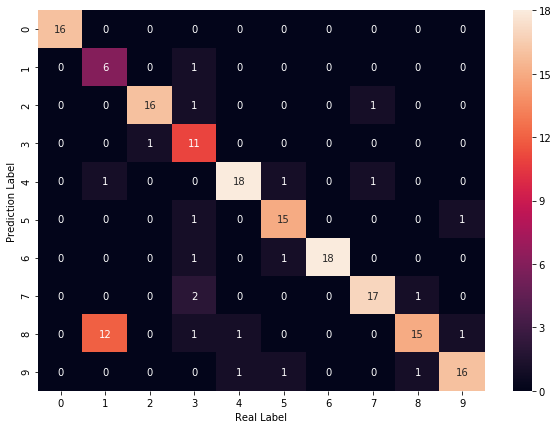

In [15]:
import seaborn as sn


df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [16]:
list_P = []
for i,p_value in enumerate(pred_value):
    print("#{} min_error:{} index:{} real:{}".format(i, error_list[i], p_value[0], digits.target[1617+i]))

#0 min_error:35 index:[5] real:5
#1 min_error:27 index:[3] real:2
#2 min_error:32 index:[1 8] real:8
#3 min_error:19 index:[0] real:0
#4 min_error:32 index:[8] real:1
#5 min_error:20 index:[7] real:7
#6 min_error:21 index:[6] real:6
#7 min_error:29 index:[3] real:3
#8 min_error:21 index:[2] real:2
#9 min_error:32 index:[1] real:1
#10 min_error:34 index:[7] real:7
#11 min_error:32 index:[8] real:4
#12 min_error:27 index:[6] real:6
#13 min_error:24 index:[3] real:3
#14 min_error:33 index:[1] real:1
#15 min_error:33 index:[8] real:3
#16 min_error:29 index:[9] real:9
#17 min_error:28 index:[1] real:1
#18 min_error:33 index:[2] real:7
#19 min_error:14 index:[6] real:6
#20 min_error:24 index:[8] real:8
#21 min_error:17 index:[4] real:4
#22 min_error:24 index:[3] real:3
#23 min_error:35 index:[1] real:1
#24 min_error:15 index:[4] real:4
#25 min_error:21 index:[0] real:0
#26 min_error:24 index:[5] real:5
#27 min_error:25 index:[3] real:3
#28 min_error:30 index:[6] real:6
#29 min_error:29 index

In [17]:
pred_value = []
error_list = []

for j in range(1617):
    pred = []
    for i in range(necoc):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(10 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
print("Testset acc:{}".format(np.sum(list_P == digits.target[:1617])/1617))
winner_fitness = []
for winner in winner_list:
    #print(winner.fitness)
    winner_fitness.append(winner.fitness)
print("Avg Base Learner:{}".format(np.mean(winner_fitness)))

Testset acc:0.8744588744588745
Avg Base Learner:0.5043774998007093


In [18]:
from random import randint

list_acc = []

for iii in range(necoc):
    pred_value = []
    error_list = []


    for j in range(1617,1617+180):
        pred = []
        for i in range(iii):
            [pred_outputs, real_outputs] = get_pred_real(i, j)
            #print(pred_outputs, real_outputs)
            pred.append(pred_outputs)
        #print(np.array(pred).T)

        error = []
        for i in range(10):
            error.append(iii - np.sum(number_codes[i][:iii] == np.array(pred).T))
        #print(error)

        pred_value.append(np.where(error==np.min(error)))
        error_list.append(np.min(error))
        #print(np.where(error==np.min(error)) )
    list_P = []
    for i in pred_value:
        if (len(i[0])) == 1:
            list_P.append(i[0][0])
        else:
            random_pick = randint(0, len(i[0])-1)
            list_P.append(i[0][random_pick])
    acc = np.sum(list_P == digits.target[1617:])/180
    #print("Accuracy on training set: {}".format(acc))
    list_acc.append(acc)

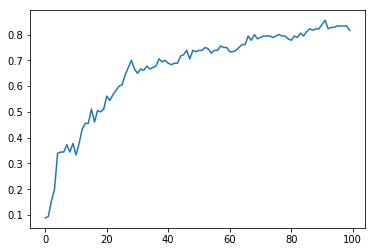

In [19]:
plt.plot(range(necoc),list_acc)
plt.show()

In [20]:
# program to check if there is exist a path between two vertices 
# of a graph 

from collections import defaultdict 

#This class represents a directed graph using adjacency list representation 
class Graph: 

	def __init__(self,vertices): 
		self.V= vertices #No. of vertices 
		self.graph = defaultdict(list) # default dictionary to store graph 

	# function to add an edge to graph 
	def addEdge(self,u,v): 
		self.graph[u].append(v) 
	
	# Use BFS to check path between s and d 
	def isReachable(self, s, d): 
		# Mark all the vertices as not visited 
		visited =[False]*(self.V) 

		# Create a queue for BFS 
		queue=[] 

		# Mark the source node as visited and enqueue it 
		queue.append(s) 
		visited[s] = True

		while queue: 

			#Dequeue a vertex from queue 
			n = queue.pop(0) 
			
			# If this adjacent node is the destination node, 
			# then return true 
			if n == d: 
				return True

			# Else, continue to do BFS 
			for i in self.graph[n]: 
				if visited[i] == False: 
					queue.append(i) 
					visited[i] = True
		# If BFS is complete without visited d 
		return False
    
    
def findAllPath(graph,start,end,path=[]):
    path = path +[start]
    if start == end:
        return [path]
 
    paths = [] #存储所有路径    
    for node in graph[start]:
        if node not in path:
            newpaths = findAllPath(graph,node,end,path) 
            for newpath in newpaths:
                paths.append(newpath)
    return paths

numbers = [*range(2)]
number_of_classification = len(numbers)

list_nodes_number = []
list_connection_number = []

for winner in winner_list:
    used_nodes = list(winner.nodes.keys())
    # create a dict for mapping 
    l1 = numbers + config.genome_config.input_keys + used_nodes[number_of_classification:]
    l2 = range(len(l1))
    dict_nodes = dict(zip(l1, l2))

    ### 将节点加入图
    g = Graph(len(l1))# inputs + outputs + used  
    # add connections in the graph
    for cg in winner.connections.values():
        if cg.enabled:
            g.addEdge(dict_nodes[cg.key[0]],dict_nodes[cg.key[1]])

    v = numbers
    list_connections = []
    for vi in v:
        for u in range(number_of_classification, len(config.genome_config.input_keys) + number_of_classification):
            list_connections.append(g.isReachable(u, vi))

    nodes_inputs = range(number_of_classification, number_of_classification+ 64)
    nodes_outputs = range(number_of_classification)
    nodes_mid = range(number_of_classification + 64, len(dict_nodes))

    # 找到所有输入和输出连接的路
    all_path = []
    for u in nodes_inputs:
        for v in nodes_outputs:
            path = findAllPath(g.graph, u, v)
            if path:
                all_path = all_path + path

    # 得到最长路，以及每个节点在哪个层级
    max_length = max([len(x) for x in all_path])
    nodes_tuples_list = []
    for path in all_path:
        #print(path)
        for node in path:
            nodes_tuples_list.append([node, path.index(node)])

    # 确定节点的层级（消除重复）       
    nodes_tuples_fixed_list = []
    for index in range(max_length):
        for nodes in nodes_tuples_list:
            node, node_index = nodes[0], nodes[1]
            if node_index == index: 
                if nodes not in nodes_tuples_fixed_list:
                    nodes_tuples_fixed_list.append(nodes)


    # 所有有连接的节点
    all_used_nodes = []
    for node in nodes_tuples_fixed_list:
        if node[0] not in all_used_nodes:
            all_used_nodes.append(node[0])

    # 确定节点的层级（最终确定）
    nodes_tuples_fixed_list_final = []

    for node in all_used_nodes:
        if node in nodes_inputs:
            nodes_tuples_fixed_list_final.append([node, 0])
        elif node in nodes_outputs:
            nodes_tuples_fixed_list_final.append([node, max_length - 1])
        else:
            list_node = []
            for nodes in nodes_tuples_fixed_list:
                if node == nodes[0]:
                    list_node.append(nodes)
            layer = 0
            for ele in list_node:
                # 删除重复项，取最大
                if ele[1] > layer:
                    layer = ele[1]
            nodes_tuples_fixed_list_final.append([node,layer])


    # 每个层级的节点合数
    length_of_layers = []
    number_of_nodes = 0
    for index in range(max_length):
        for nodes in nodes_tuples_fixed_list_final:
            node, node_index = nodes[0], nodes[1]
            if node_index == index: 
                number_of_nodes += 1
        length_of_layers.append(number_of_nodes)

    length_of_each_layer = []
    length_of_each_layer.append(length_of_layers[0])
    for i in range(1, max_length):
        length_of_each_layer.append(length_of_layers[i] - length_of_layers[i-1])

    # 输出每个层级的节点个数
    #print("length of each layers:", length_of_each_layer)

    # 所有端到端的路
    all_path_side2side = []
    for path in all_path:
        if len(path) == 2:
            all_path_side2side.append(path)
        else:
            for i in range(len(path)-1):
                all_path_side2side.append([path[i],path[i+1]])

    # 定义节点到绘图的字典
    dict_nodes_graph = dict()
    count_number_layer = [0] * max_length
    for nodes in nodes_tuples_fixed_list_final:
        node, layer = nodes
        dict_nodes_graph[node] = [count_number_layer[layer], layer]
        count_number_layer[layer] += 1
    list_nodes_number.append(np.sum(length_of_each_layer))
    list_connection_number.append(len(all_path_side2side))
    #print("Number of nodes:{} Number of connections:{}".format(np.sum(length_of_each_layer),len(all_path_side2side)))
print("Total nodes:{} Total connections::{}".format(np.sum(list_nodes_number), np.sum(list_connection_number)))

Total nodes:1964 Total connections::2297
